# Описание проекта

Заказчик - интернет-магазин по продаже видео игр. Компания хочет спланировать рекламный бюджет и сконцентрироваться на потенциально популярном продукте. Имеются исторические данные (до 2016 г.) из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах и платформах. 

**Цель исследования:** выявить факторы, определяющие потенциально прибыльную игру, и дать рекомендации по планированию рекламной кампании.

Содержание:
1. [Изучение общей информации о данных](#1);
2. [Предобработка данных](#2);
3. [Исследовательский анализ](#3);
4. [Определение портрета пользователя по регионам](#4);
5. [Проверка гипотез](#5);
6. [Общий вывод](#6)

## Изучение данных из файлов¶
<a id='1'></a>

In [1]:
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.duplicated().sum()

0

**Вывод**

Датасет содержит 16715 строк, явные дубликаты отсутствуют, в нескольких столбцах есть пропуски. Столбцы `Year_of_Release`, `User_Score` следует привести к типу данных int и float соответственно.

## Подготовка данных
<a id='2'></a>

In [6]:
# Приведем к нижнему регистру названия столбцов 
data.columns = data.columns.str.lower()

### Работа с пропусками

In [7]:
# Выведем информацию о количестве пропусков
display(pd.DataFrame(round((data.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
name,0.01
platform,0.00
year_of_release,1.61
genre,0.01
na_sales,0.00
eu_sales,0.00
jp_sales,0.00
other_sales,0.00
critic_score,51.32
user_score,40.09


Столбцы `critic_score`, `user_score` и `rating` содержат большое количество пропусков. Возможно, одна из причин - наличие в датасете старых игр, по которым рейтинги не устанавливались либо найти информацию о рейтингах не удалось.

**Обработка пропусков по столбцу `name`**

In [8]:
# выведем строки с пропущенными названиями игр
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


По двум играм отсутствует информация о названии, жанре, оценке критиков и пользователей, рейтинг. Учитывая незначительное количество, можно убрать эти строки из датасета.

In [9]:
data = data.dropna(subset=['name'])

**Обработка пропусков по столбцу `year_of_release`**

In [10]:
# выведем строки с пропущенными годами выпуска
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Имеется 269 строк с отсутствующими данными по году выпуска. Заметим, что в конце некоторых названий встречаются четырехзначные цифры, которые могут означать год выпуска. Проверим все названия с пропущенными годами выпуска на наличие цифр.

In [11]:
# Функция проверяет передаваемое название name и возвращает True, если содержится хотя бы одна цифра
def has_numbers(name):
    return any(char.isdigit() for char in name)

# Записываем в переменную названия с отсутствующей информацией по году выпуска
names_to_check = data[data['year_of_release'].isna()]['name']

# Выводим названия, в которых есть цифры
for i in names_to_check:
    if has_numbers(i):
        print(i)

Madden NFL 2004
FIFA Soccer 2004
wwe Smackdown vs. Raw 2006
Call of Duty 3
Triple Play 99
LEGO Harry Potter: Years 5-7
NASCAR Thunder 2003
Hitman 2: Silent Assassin
LEGO Harry Potter: Years 5-7
Yakuza 4
LEGO Harry Potter: Years 5-7
Madden NFL 07
MLB SlugFest 20-03
PES 2009: Pro Evolution Soccer
Madden NFL 11
Test Drive Unlimited 2
LEGO Harry Potter: Years 5-7
Monster Hunter 2
Metal Gear Solid 2: Substance
Test Drive Unlimited 2
Madden NFL 06
Madden NFL 2002
NBA Street Vol. 2
Tiger Woods PGA Tour 07
NFL GameDay 2003
LEGO Harry Potter: Years 5-7
NBA Live 2003
Dragon Ball Z: Budokai Tenkaichi 2 (JP sales)
Tropico 4
Tomb Raider (2013)
Bejeweled 3
All-Star Baseball 2005
NBA Live 2003
Unreal Championship 2: The Liandri Conflict
Indy 500
Disgaea 3: Absence of Detention
LEGO Harry Potter: Years 5-7
College Hoops 2K6
BioShock 2
Jet X20
Big Beach Sports 2
LEGO Harry Potter: Years 5-7
Famista 64
Dead Space 3
Test Drive Unlimited 2
All-Star Baseball 2005
Bejeweled 3
Bejeweled 3
Major League Baseba

Как видим, в полученной выборке по ряду игр (в основном, спортивного жанра, исходя из названия) возможно восстановить год выпуска по названию. Учтем, что спортивные игры обычно выпускаются в году, предшествующем году сезона. Создадим словарь, где ключом будет название игры, а значением - год выпуска. 

In [12]:
name_year_dict = {
    'Madden NFL 2004' : 2003,    
    'FIFA Soccer 2004' : 2003,
    'wwe Smackdown vs. Raw 2006' : 2005,
    'Triple Play 99' : 1998,
    'NASCAR Thunder 2003' : 2002,
    'Madden NFL 07' : 2006,
    'MLB SlugFest 20-03' : 2002,
    'PES 2009: Pro Evolution Soccer' : 2008,
    'Madden NFL 11' : 2010,
    'Madden NFL 06' : 2005,
    'Madden NFL 2002' : 2001,
    'Tiger Woods PGA Tour 07' : 2006,
    'NFL GameDay 2003' : 2002,
    'NBA Live 2003' : 2002,
    'Tomb Raider (2013)' : 2013,
    'All-Star Baseball 2005' : 2004,
    'College Hoops 2K6' : 2005,
    'Major League Baseball 2K6' : 2005,
    'Tour de France 2011' : 2010,
    'Sega Rally 2006' : 2006,
    'Major League Baseball 2K8' : 2007,
    'PDC World Championship Darts 2008' : 2007,
    'Football Manager 2007' : 2006
            }

Заполним все пропуски нулями. Далее напишем функцию, которая будет заменять нулевое значение на значение из словаря name_year_dict по названию игры. 

In [13]:
data['year_of_release'] = data['year_of_release'].fillna(0)

def replace_zero_to_year(df):
    '''
    Возвращает значение из словаря name_year_dict, 
    если встречается 0 в колонке year_of_release и название игры есть в name_year_dict. 
    Иначе возвращает исходное значение year_of_release.
    '''
    if (df['year_of_release'] == 0 and 
        df['name'] in name_year_dict.keys()):
        return name_year_dict[df['name']]
    return df['year_of_release']

data['year_of_release'] = data.apply(replace_zero_to_year, axis=1)
len(data.query('year_of_release == 0'))

243

**Итог** - восстановлены значения года выпуска по 26 строкам, по остальным пропуски заменены на нули.

In [14]:
# приведем столбец к типу int
data['year_of_release'] = data['year_of_release'].astype('int')

**Обработка пропусков по столбцу `critic_score`**

In [15]:
# поставим на пропуски заглушку (-1), т.к. данные восстановить невозможно
data['critic_score'] = data['critic_score'].fillna(-1)
# приведем столбец к типу int
data['critic_score'] = data['critic_score'].astype('int')

**Обработка пропусков по столбцу `user_score`**

In [16]:
data['user_score'].describe()

count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object

Помимо пропусков, столбец содержит 2424 значений "tbd", что может означать "to be determined". Скорее всего, количество пользовательских отзывов было недостаточным для определение итоговой оценки игры. Учитывая, что в распоряжении нет данных по всем пользовательским оценкам конкретной игры, можно принять "tbd" как отсутствующее значение NaN.

In [17]:
# переведем значения в числовой формат, "tbd" заменим на NaN
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
# поставим на пропуски заглушку (-1), т.к. данные восстановить невозможно
data['user_score'] = data['user_score'].fillna(-1)
# округлим значения до десятых
data['user_score'] = data['user_score'].round(decimals=1)

**Обработка пропусков по столбцу `rating`**

In [18]:
data['rating'].isna().sum()

6764

In [19]:
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

Столбец содержит 8 возрастных категорий, 6764 пропусков. На основании имеющихся данных восстановить значения пропусков не представляется возможным. Укажем вместо NaN значение "н/д".

In [20]:
data['rating'] = data['rating'].fillna('н/д')

**Вывод**

В ходе подготовки данных к анализу были обработаны пропуски, часть значений была восстановлена. Значения столбцов приведены к нужному типу данных.

## Исследовательский анализ данных
<a id='3'></a>

### Распределение игр по годам

Посмотрим, сколько игр выпускалось в разные годы. Исключим из датасета игры с нулевым годом (ранее пропуски были заменены нулями).

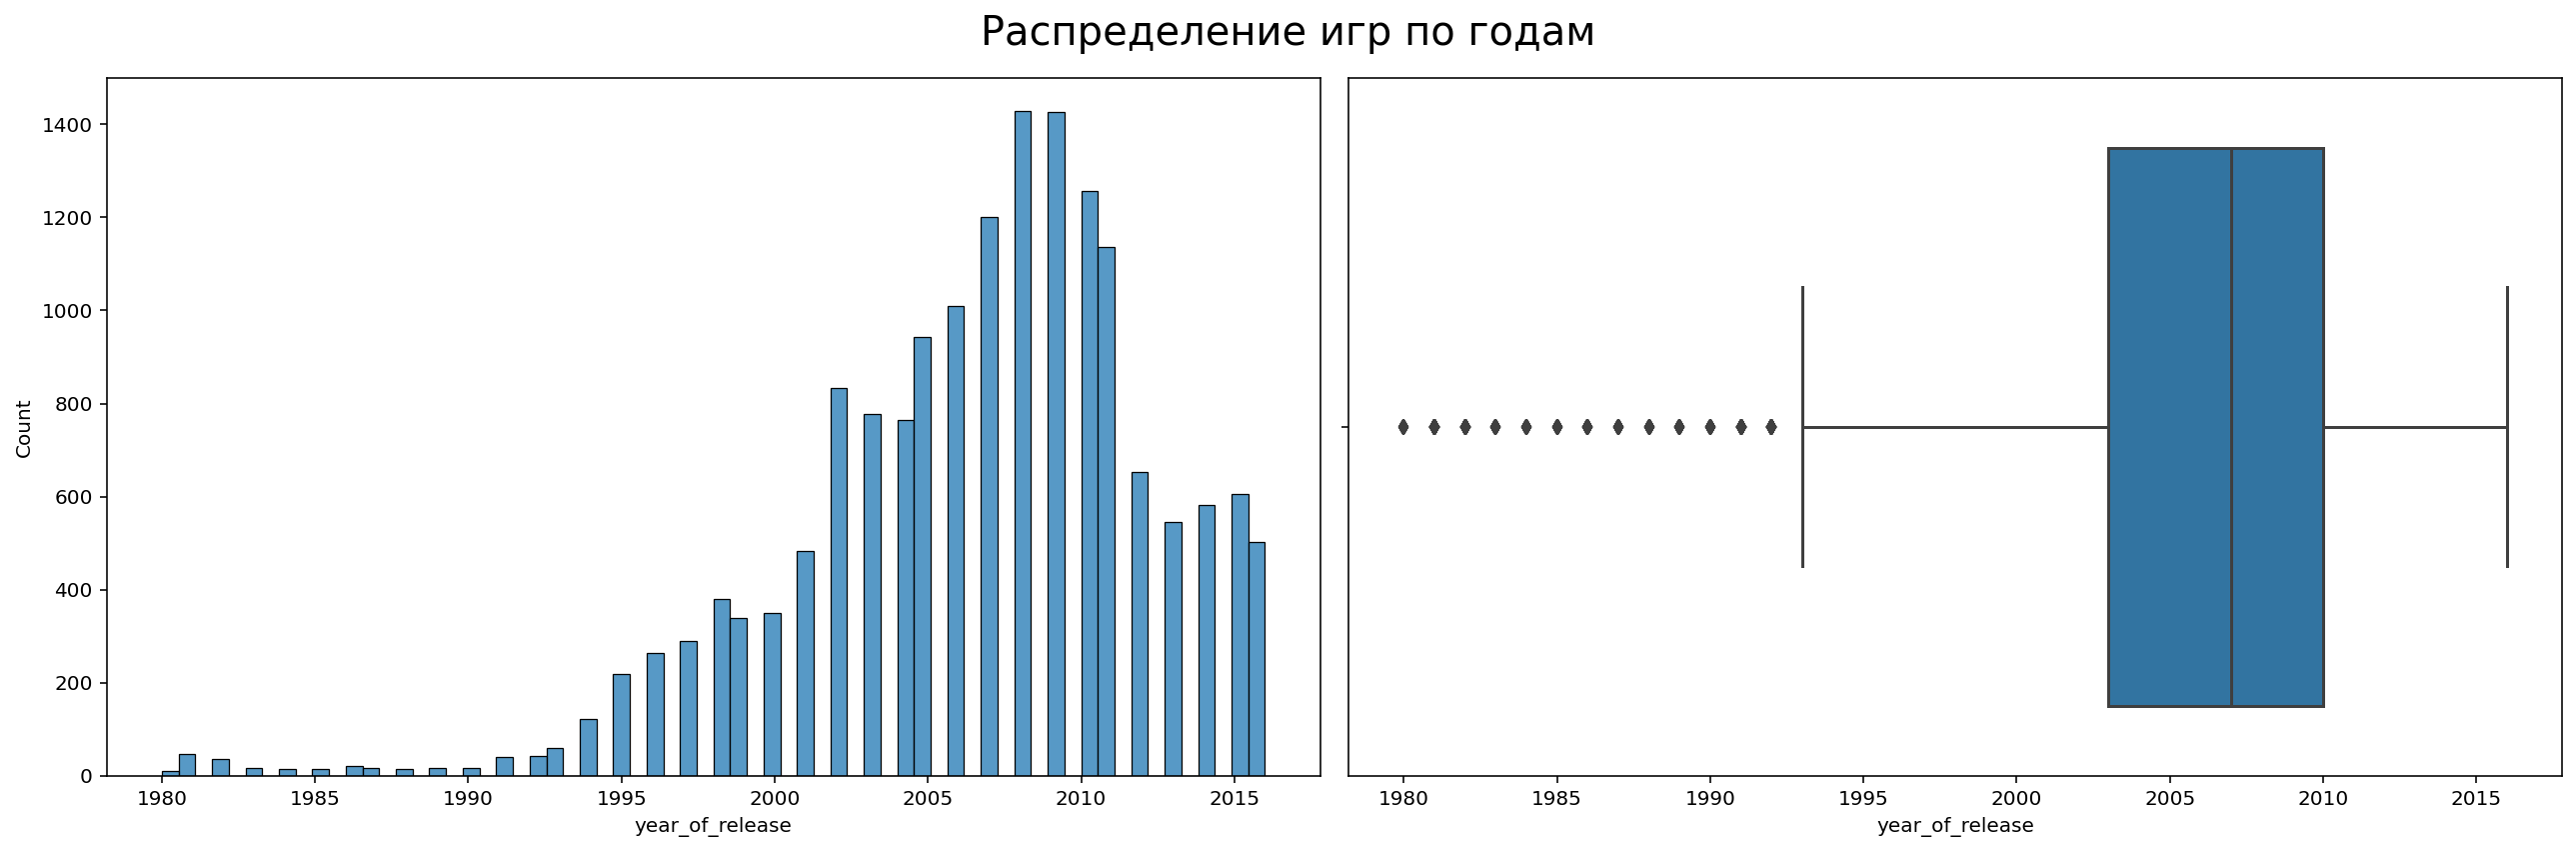

In [21]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('Распределение игр по годам', fontsize=20)
sns.histplot(x='year_of_release', data=data.query('year_of_release != 0'), ax=axs[0])
sns.boxplot(x='year_of_release', data=data.query('year_of_release != 0'), ax=axs[1])
fig.tight_layout()

Наиболее активно игры производились с 1993 года. С этого года продажи росли быстрыми темпами, достигнув пика к 2008-2009 годам. Далее наблюдается спад, в период с 2011 по 2016 выпускалось около 600 шт. в год. Значимый период для анализа - с 1993 года.

### Распределение игр по платформам

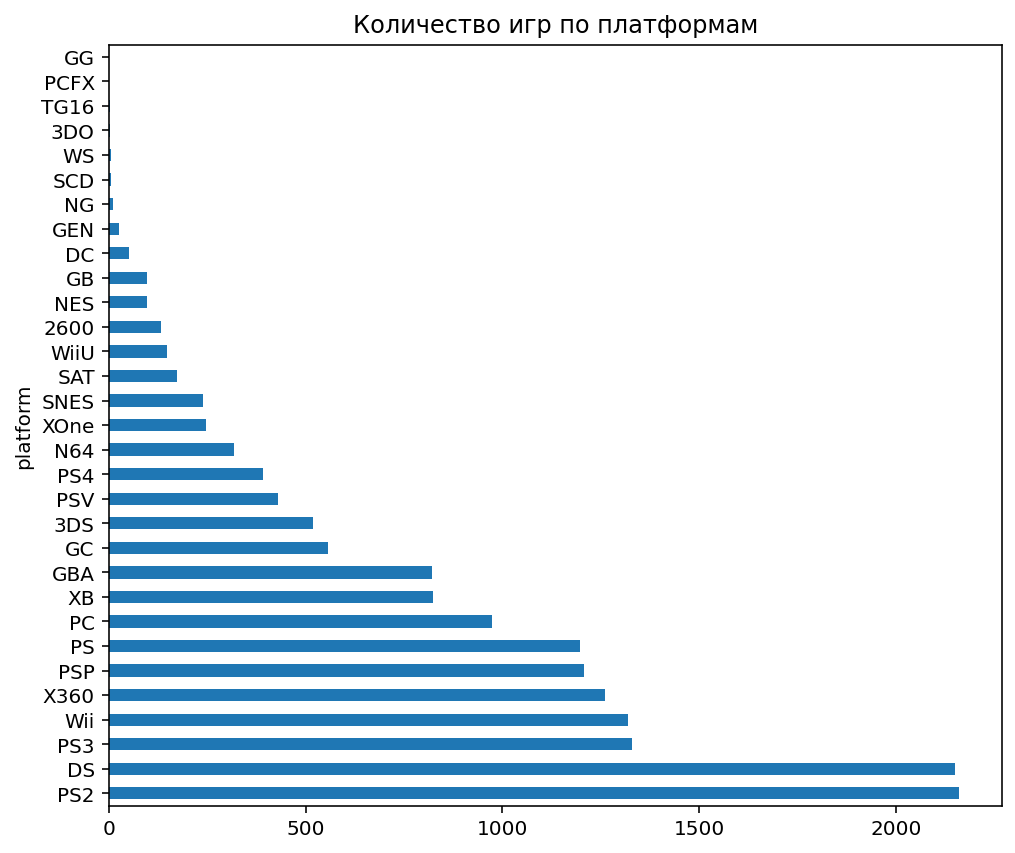

In [22]:
(data.pivot_table(index='platform', values='name', aggfunc='count')
 .sort_values(by='name', ascending=False)
 .plot(kind='barh', figsize=(8,7), legend=False, title='Количество игр по платформам'))
plt.show()

In [23]:
# Добавим столбец с суммарными продажами
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

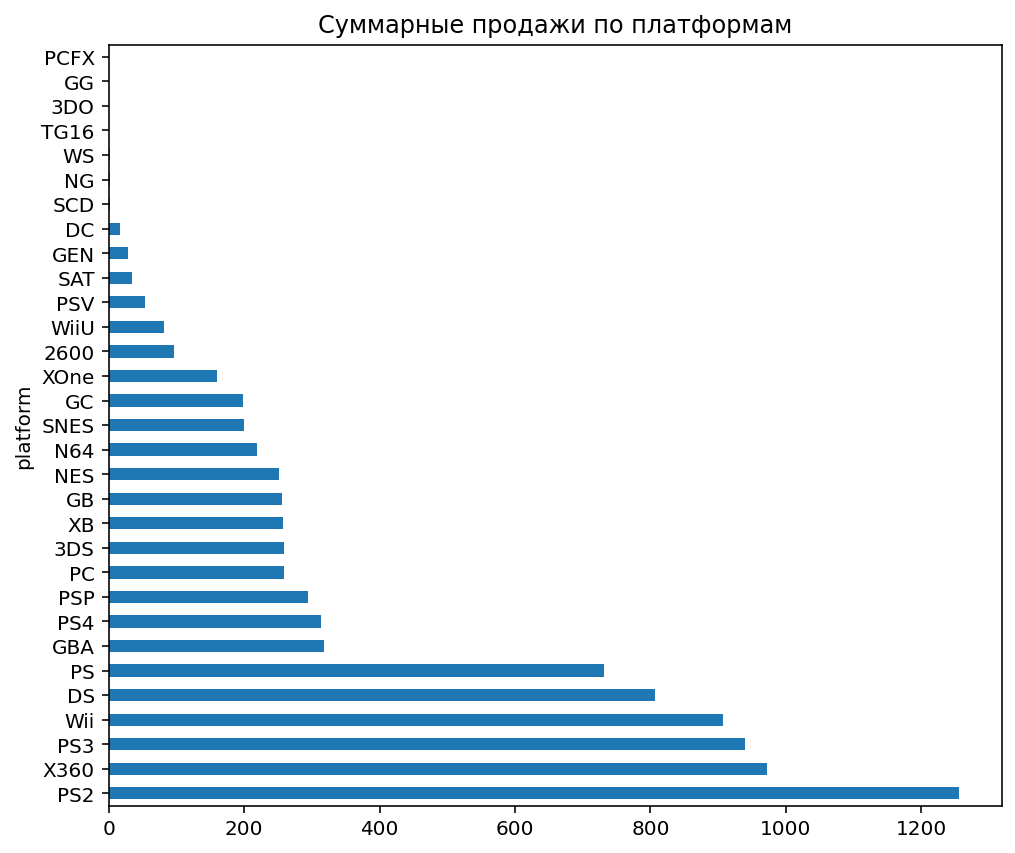

In [24]:
(data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .plot(kind='barh', figsize=(8,7), legend=False, title='Суммарные продажи по платформам'))
plt.show()

Платформы с наибольшими суммарными продажами: PS2, X360, PS3, Wii, DS, PS

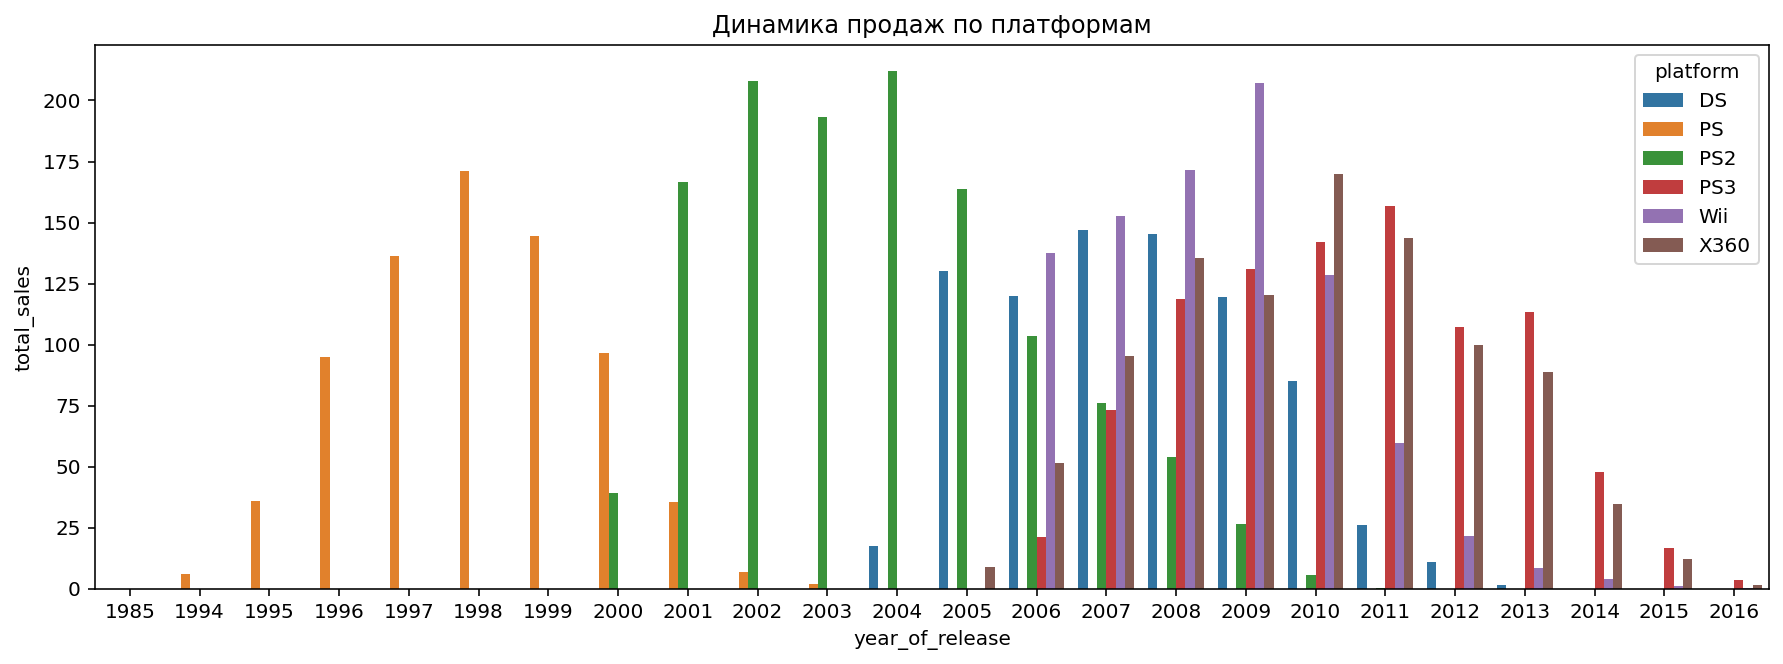

In [25]:
top_platforms_sales = (
    data.query('platform in ["PS2", "X360", "PS3", "Wii", "DS", "PS"] and year_of_release != 0')
    .pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum')
    .reset_index()
)

fig = plt.figure(figsize=(15,5))
sns.barplot(x='year_of_release', y='total_sales', data=top_platforms_sales, hue='platform')
plt.title('Динамика продаж по платформам')
plt.show()

Средний жизненный цикл платформы 8-9 лет. Обычно максимальные продажи приходятся на середину цикла.

### Выбор актуального периода для прогноза на 2017 год

Ранее был определен средний жизненный цикл для топ-6 платформ по количеству продаж. Проанализируем также другие платформы, т.к. рассмотренные ранее теряют или уже потеряли свою актуальность (снижение продаж к 2016 году). 

In [26]:
def sales_per_platform(platforms):
    top_platforms_sales = (
    data.query('platform in @platforms and year_of_release != 0')
    .pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum')
    .reset_index())
    
    fig = plt.figure(figsize=(15,5))
    sns.barplot(x='year_of_release', y='total_sales', data=top_platforms_sales, hue='platform')
    plt.title('Динамика продаж по платформам')
    plt.show()

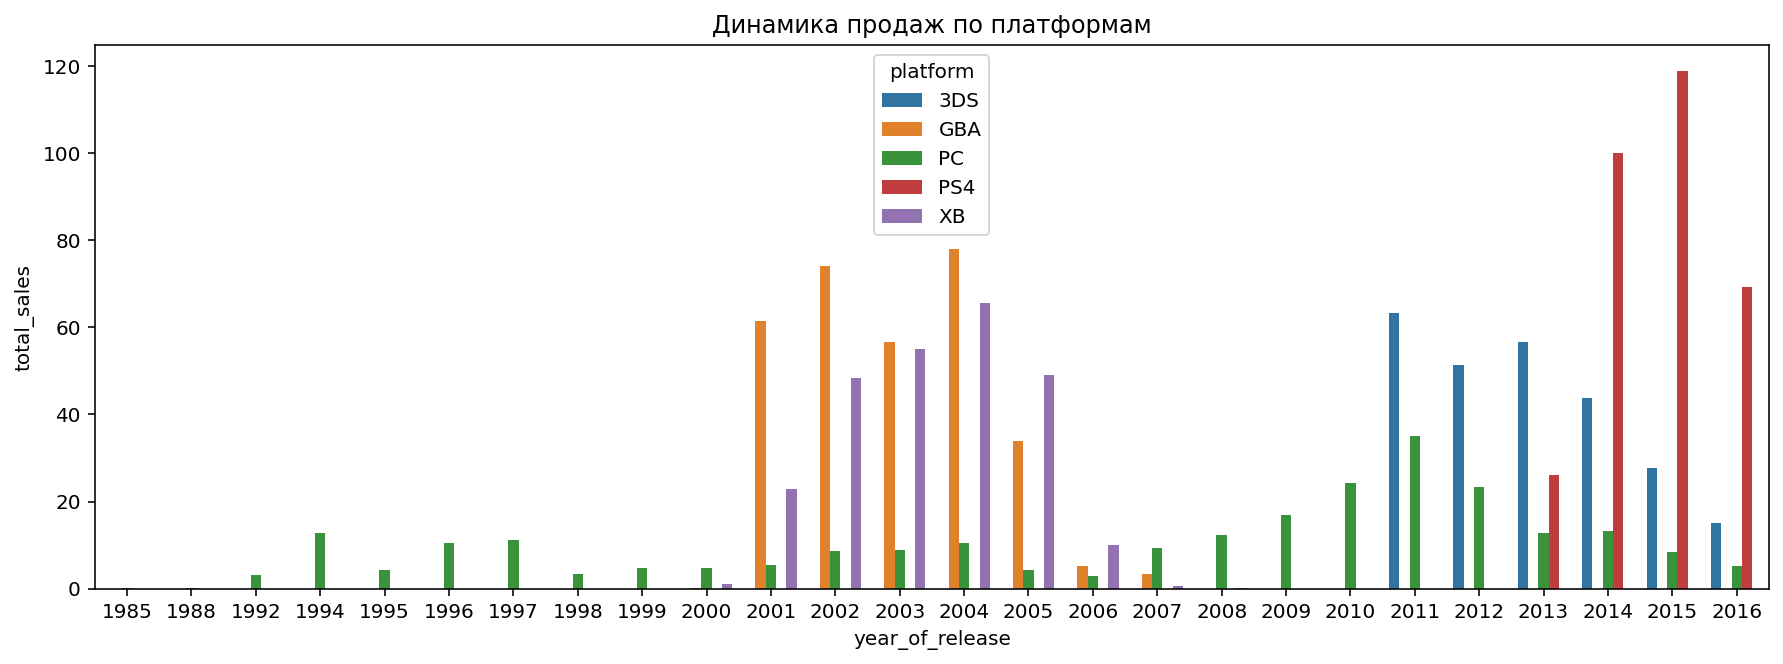

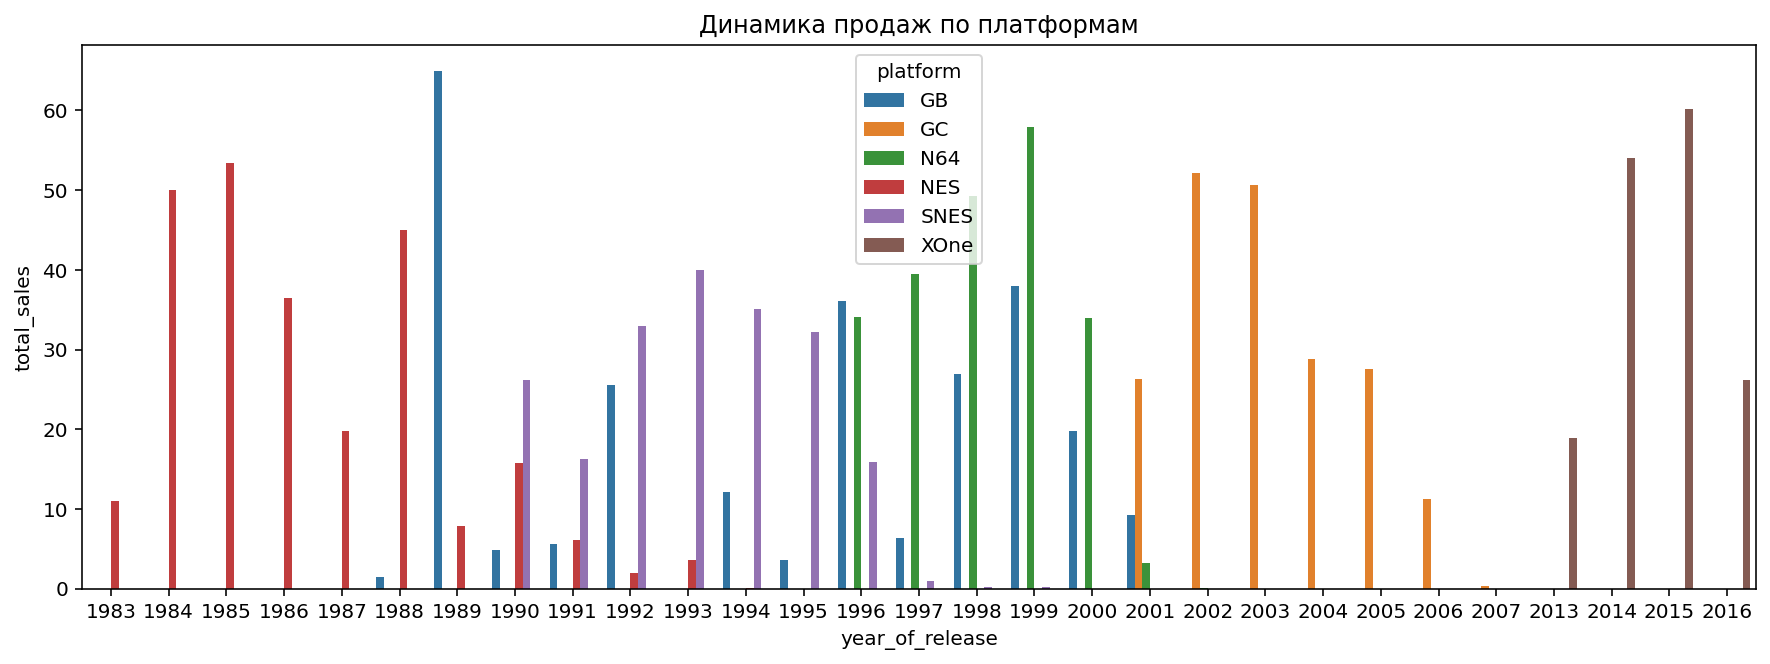

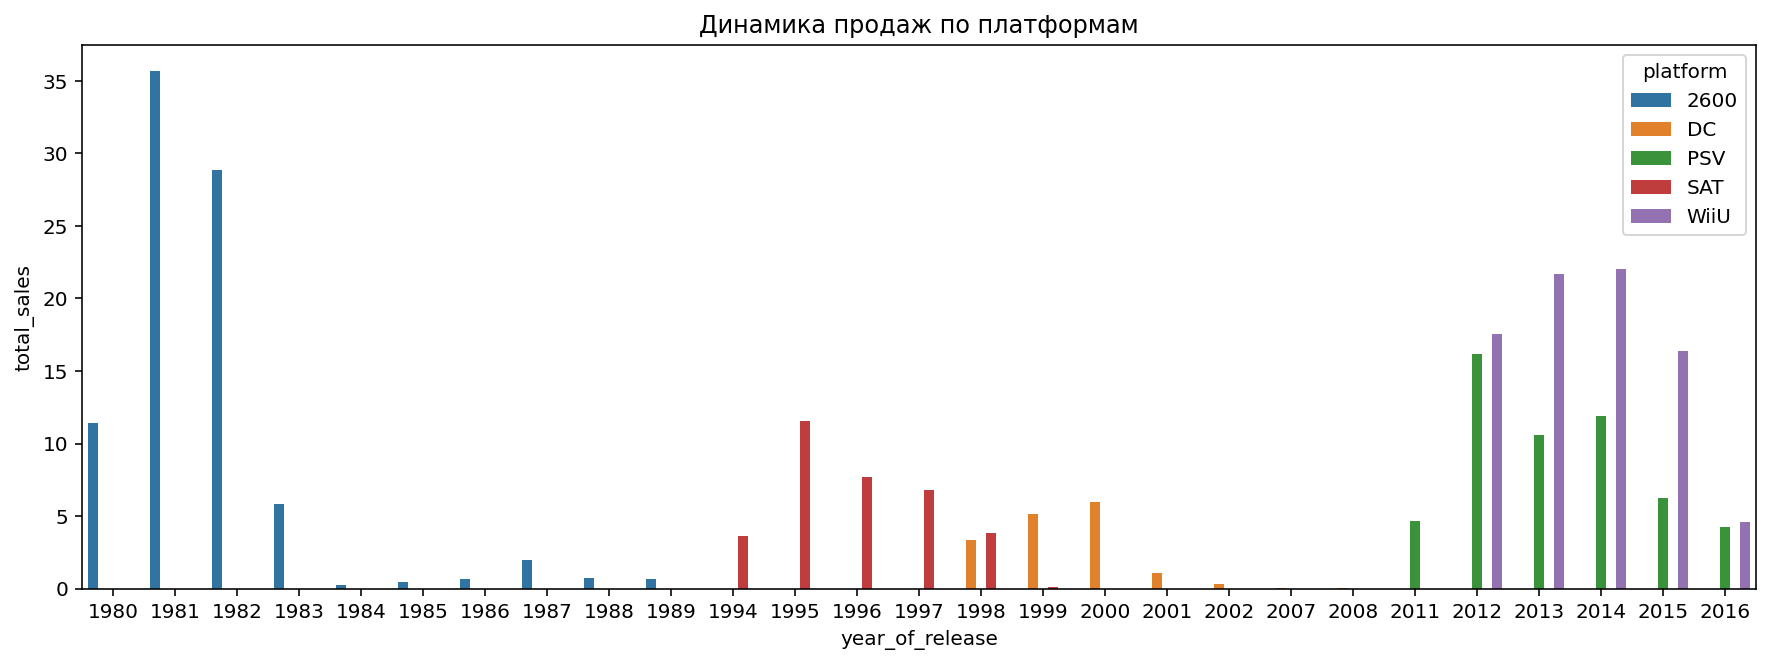

In [27]:
platforms_1 = ["GBA", "PS4", "PS5", "PC", "3DS", "XB"]
platforms_2 = ["GB", "NES", "N64", "SNES", "GC", "XOne"]
platforms_3 = ["2600", "WiiU", "PSV", "SAT", "Gen", "DC"]
sales_per_platform(platforms_1)
sales_per_platform(platforms_2)
sales_per_platform(platforms_3)

Как видим, по другим платформам жизненный цикл короче (около 6 лет), за исключением PC. Прослеживаются платформы, которые остаются популярными на 2016 год (PS4, XOne, PC). Часть платформ теряет актуальность, многие платформы исчезли с рынка. Сильный рост продаж в 2008-2009 произошел в большей степени за счет популрности платформ Wii, X360, PS3. Но к концу анализируемого периода данные платформы стали неактуальными. Для планирования рекламной кампании на 2017 год целесообразно выбрать период, в котором часть платформ еще не потеряли свою актуальность. 
Учитывая средний жизненный цикл 6-9 лет, выберем **границы актуального периода с 2012 по 2016** и будем использовать его при дальнейшем анализе.

In [28]:
data_filtered = data.query('year_of_release >= 2012')

### Выбор потенциально прибыльных платформ

Определим, какие платформы лидируют по продажам, растут или падают в актуальном периоде.

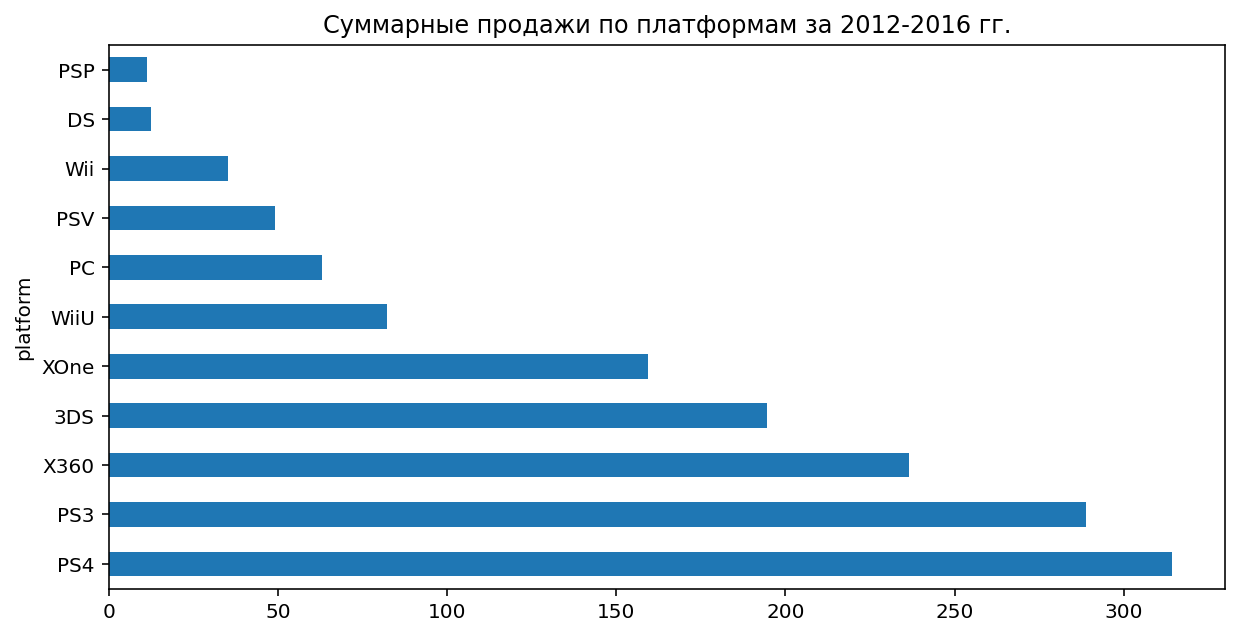

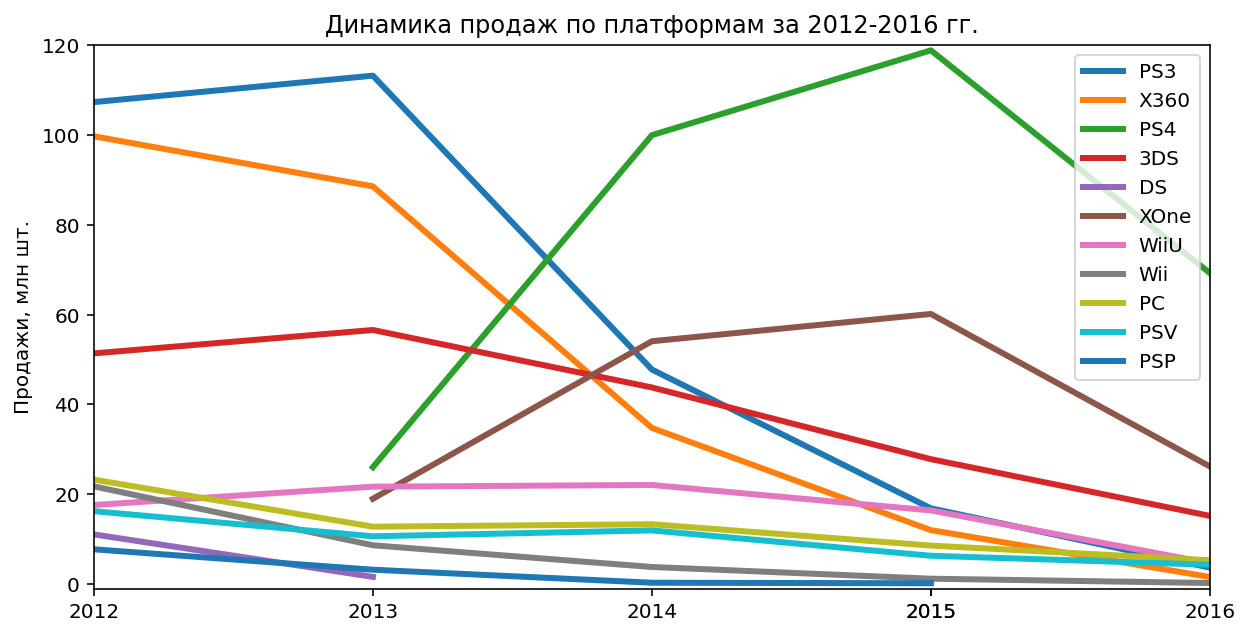

In [29]:
(data_filtered.pivot_table(index='platform', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .plot(kind='barh', figsize=(10,5), legend=False, title='Суммарные продажи по платформам за 2012-2016 гг.'))
plt.show()

fig = plt.figure(figsize=(10,5))
for i in data_filtered['platform'].unique():
    plt.plot(data_filtered[data_filtered['platform'] == i]
         .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum'), label=i, linewidth=3)
plt.legend()
plt.title('Динамика продаж по платформам за 2012-2016 гг.')
plt.ylabel('Продажи, млн шт.')
plt.xticks([2012,2013,2014,2015,2015,2016])
plt.margins(0, 0.01)
plt.show()

Лидеры продаж за рассматриваемый период - PS3, X360, PS4. При этом максимальные продажи по PS3 и X360 приходились на 2011 год, к 2016 игры для данных платформ практически не продаются. Продажи по PS4 растут, несмотря на снижение в 2016 (возможно из-за неполных данных). Также положительная динамика наблюдается по XOne. По 3DS, Wii, WiiU, PSV продажи стабильно падают. Пo DS и PSP продажи к концу периода прекратились. По PC также наблюдается снижение, однако по данной платформе не прослеживается стандартный для других платформ жизненный цикл, продажи колеблются на протяжении длительного периода и нет оснований полагать, что в прогнозном периоде они прекратятся. 

Таким образом, можно выделить следующие **потенциально прибыльные платформы:**
- PS4;
- XOne;
- PC.

### Распределение глобальных продаж в разбивке по платформам

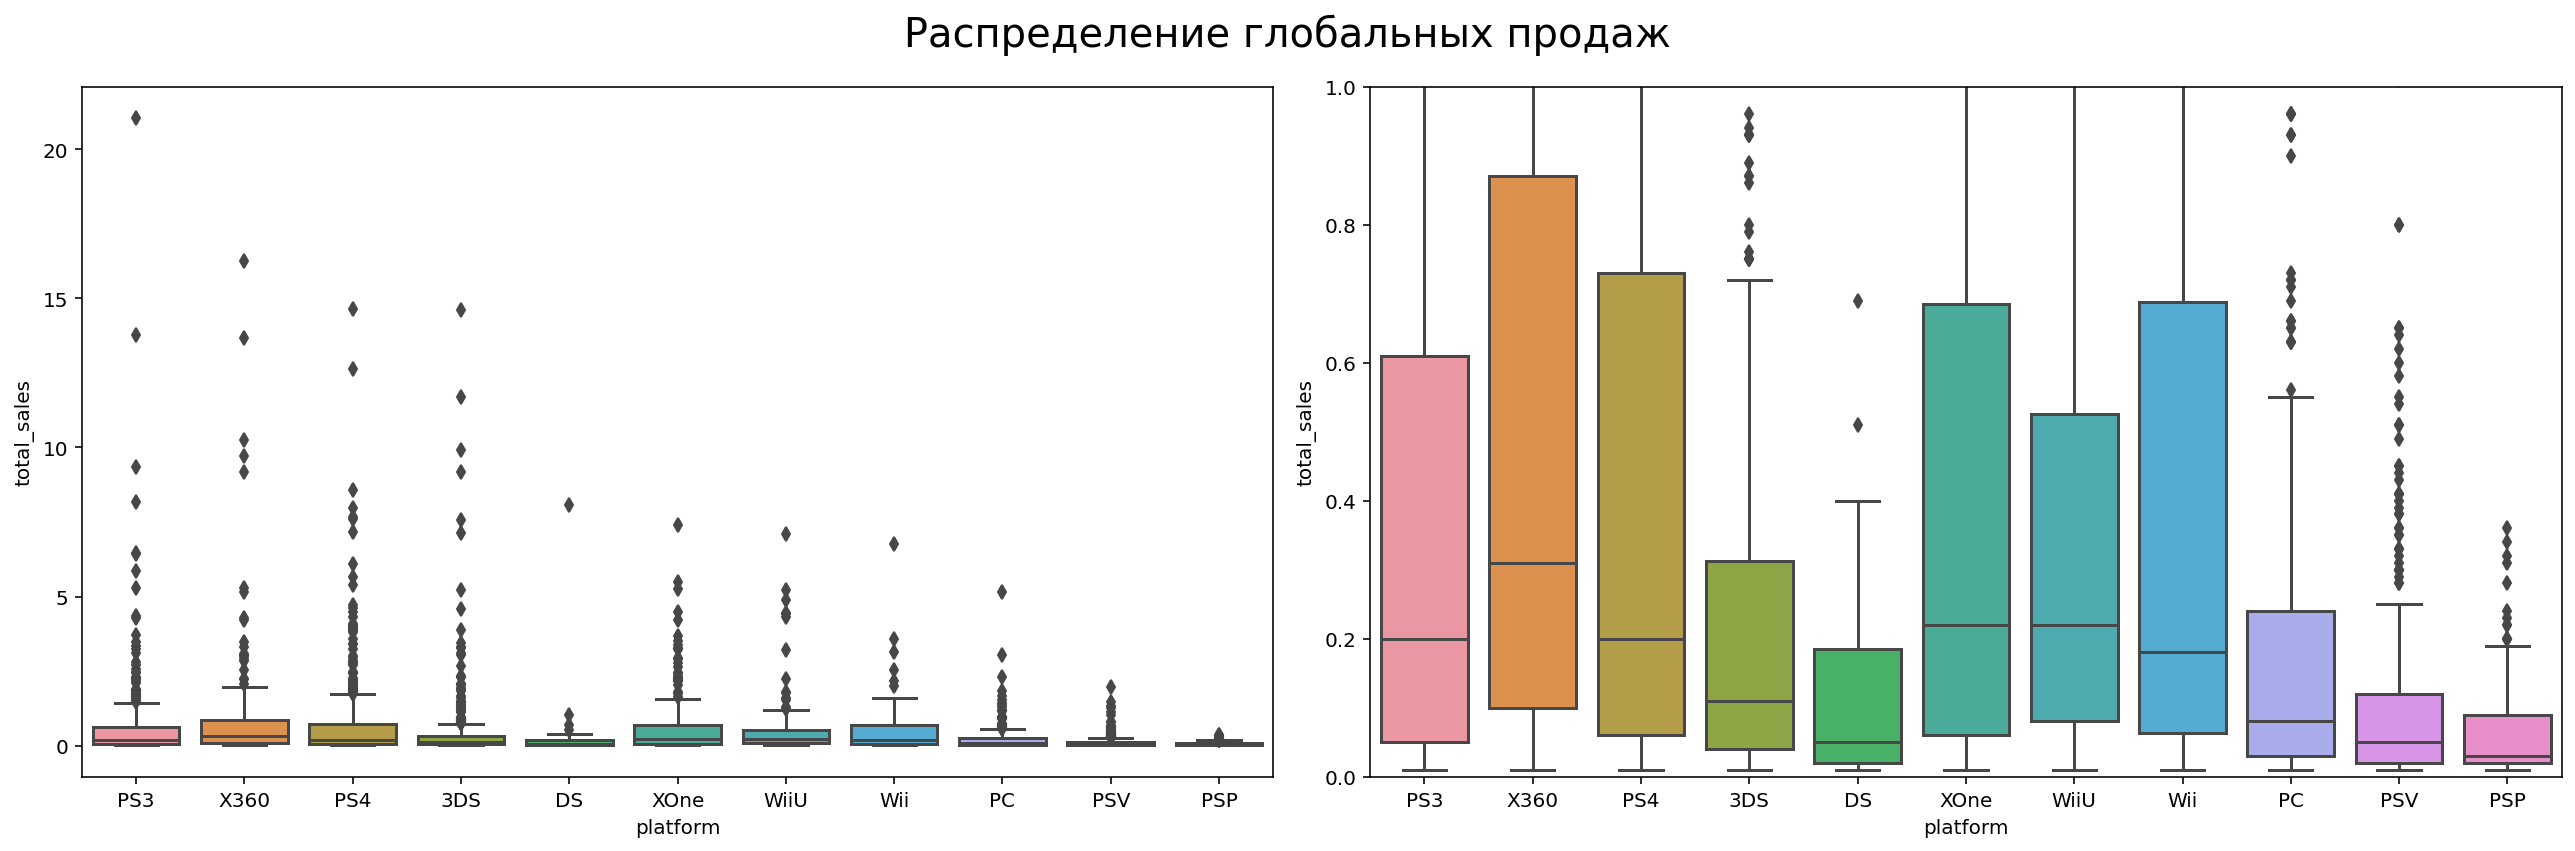

In [30]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('Распределение глобальных продаж', fontsize=20)
axs[1].set_ylim(0,1)
sns.boxplot(x='platform', y='total_sales', data=data_filtered, ax=axs[0])
sns.boxplot(x='platform', y='total_sales', data=data_filtered, ax=axs[1])
fig.tight_layout()

У X360 наибольший размах значений - на этой платформе чаще попадались игры, проданные в больших количествах. Похожая картина у PS3, PS4, XOne, Wii. Медианные значения по ним примерно равны - 50% игр на этих платформах имеют глобальные продажи около 0.2 млн копий. PC показывает более скромные результаты - лишь у 25% игр количество проданных копий составляет более 0.24 млн, большинство игр не переходят планку в 0.5 млн копий.

### Влияние на продажи отзывов пользователей и критиков

Посмотрим, как влияют на продажи внутри одной популярной платформы (PS4) отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

0.40656790206178095
-0.031957110204556424


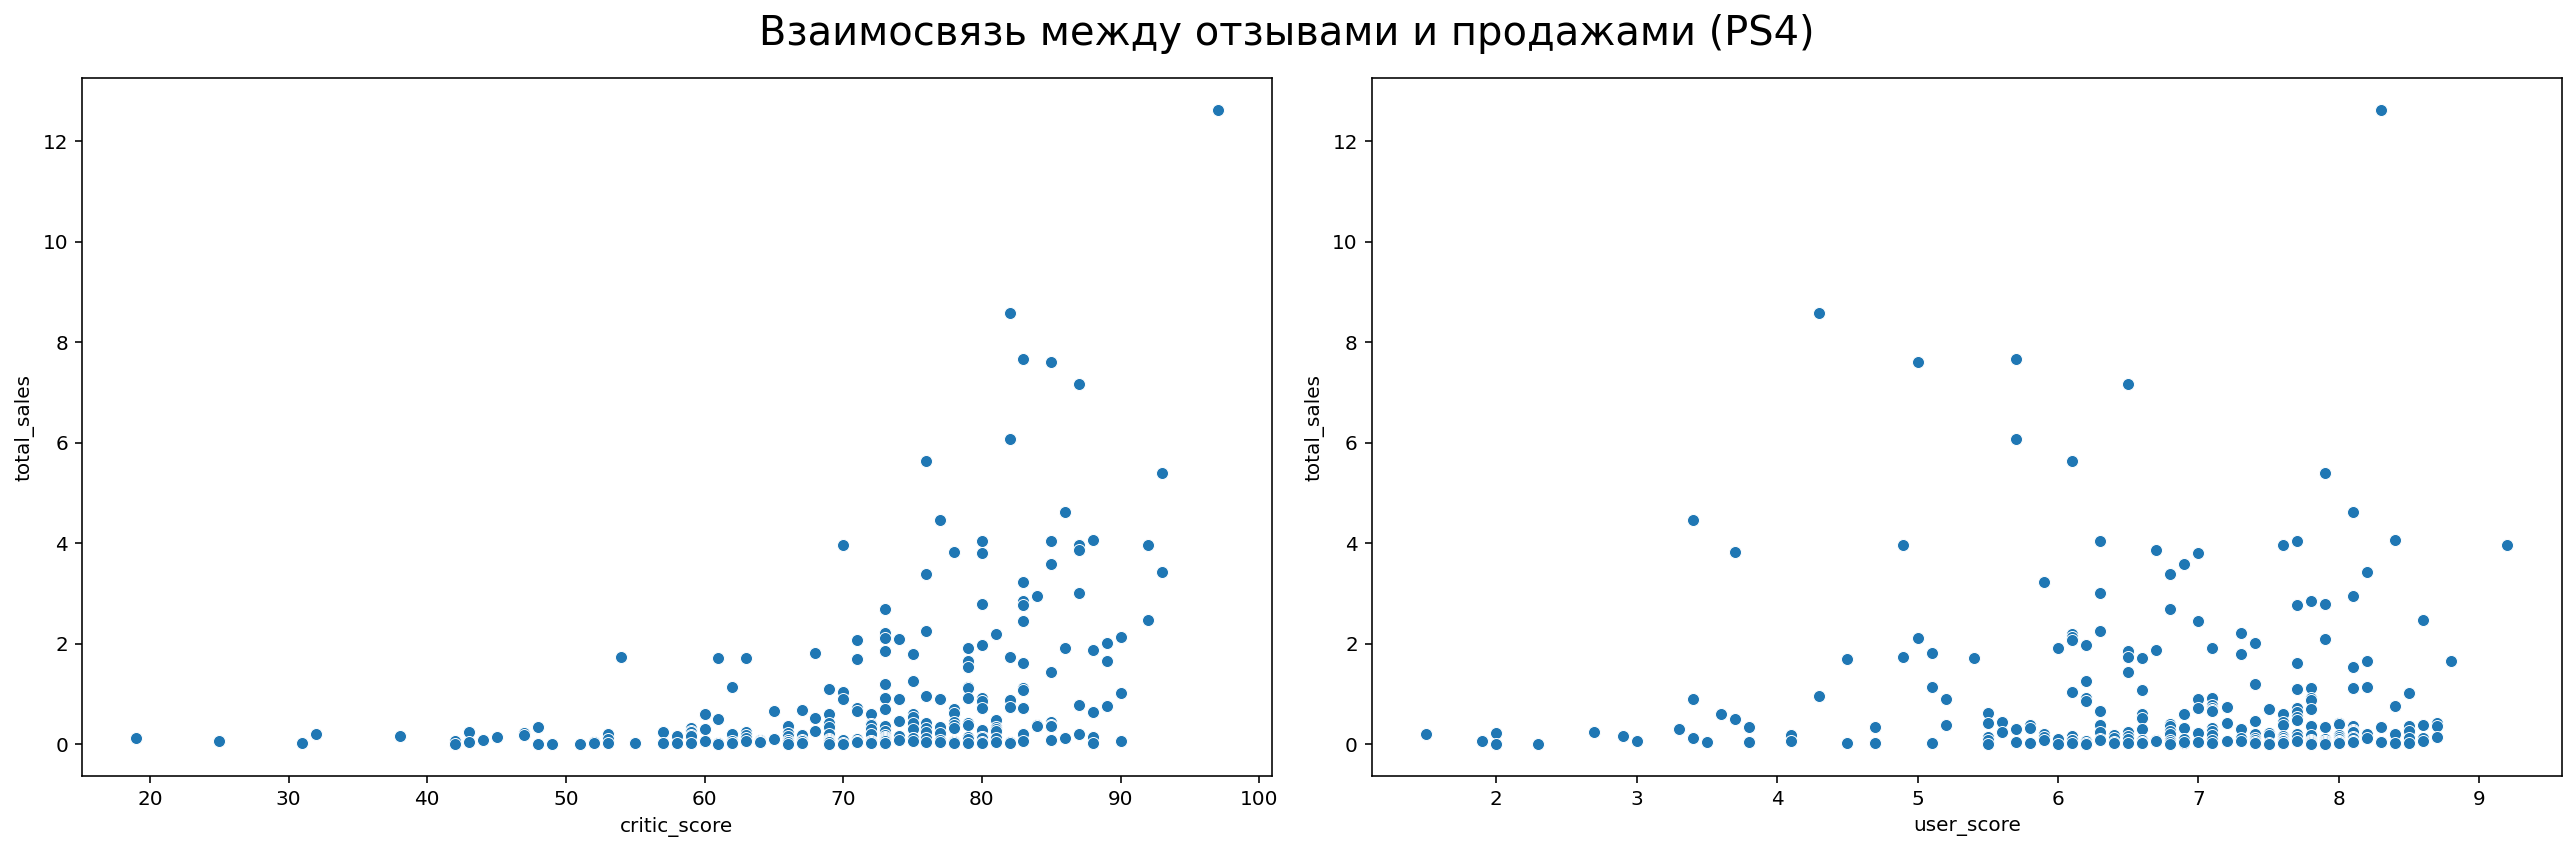

In [31]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('Взаимосвязь между отзывами и продажами (PS4)', fontsize=20)
sns.scatterplot(x='critic_score', y='total_sales', 
                data=data_filtered.query('platform == "PS4" and critic_score > 0'), ax=axs[0])
sns.scatterplot(x='user_score', y='total_sales', 
                data=data_filtered.query('platform == "PS4" and user_score > 0'), ax=axs[1])
fig.tight_layout()

# корреляция между оценкой критиков и продажами
print((data_filtered.query('platform == "PS4" and critic_score > 0')['critic_score']
.corr(data_filtered.query('platform == "PS4"')['total_sales'])))

# корреляция между оценкой пользователей и продажами
print((data_filtered.query('platform == "PS4" and user_score > 0')['user_score']
.corr(data_filtered.query('platform == "PS4"')['total_sales'])))

По платформе PS4 прослеживается небольшая прямая зависимость между оценкой критиков и продажами, особенно это видно при высокой оценке (более 70). Наличие зависимости подтверждается коэффициентом корреляции 0.41. <br>
Явной зависимости между оценками пользователей и продажами не обнаружено.

Проведем аналогичное исследование по другим платформам и посмотрим, как соотносятся полученные выводы. 

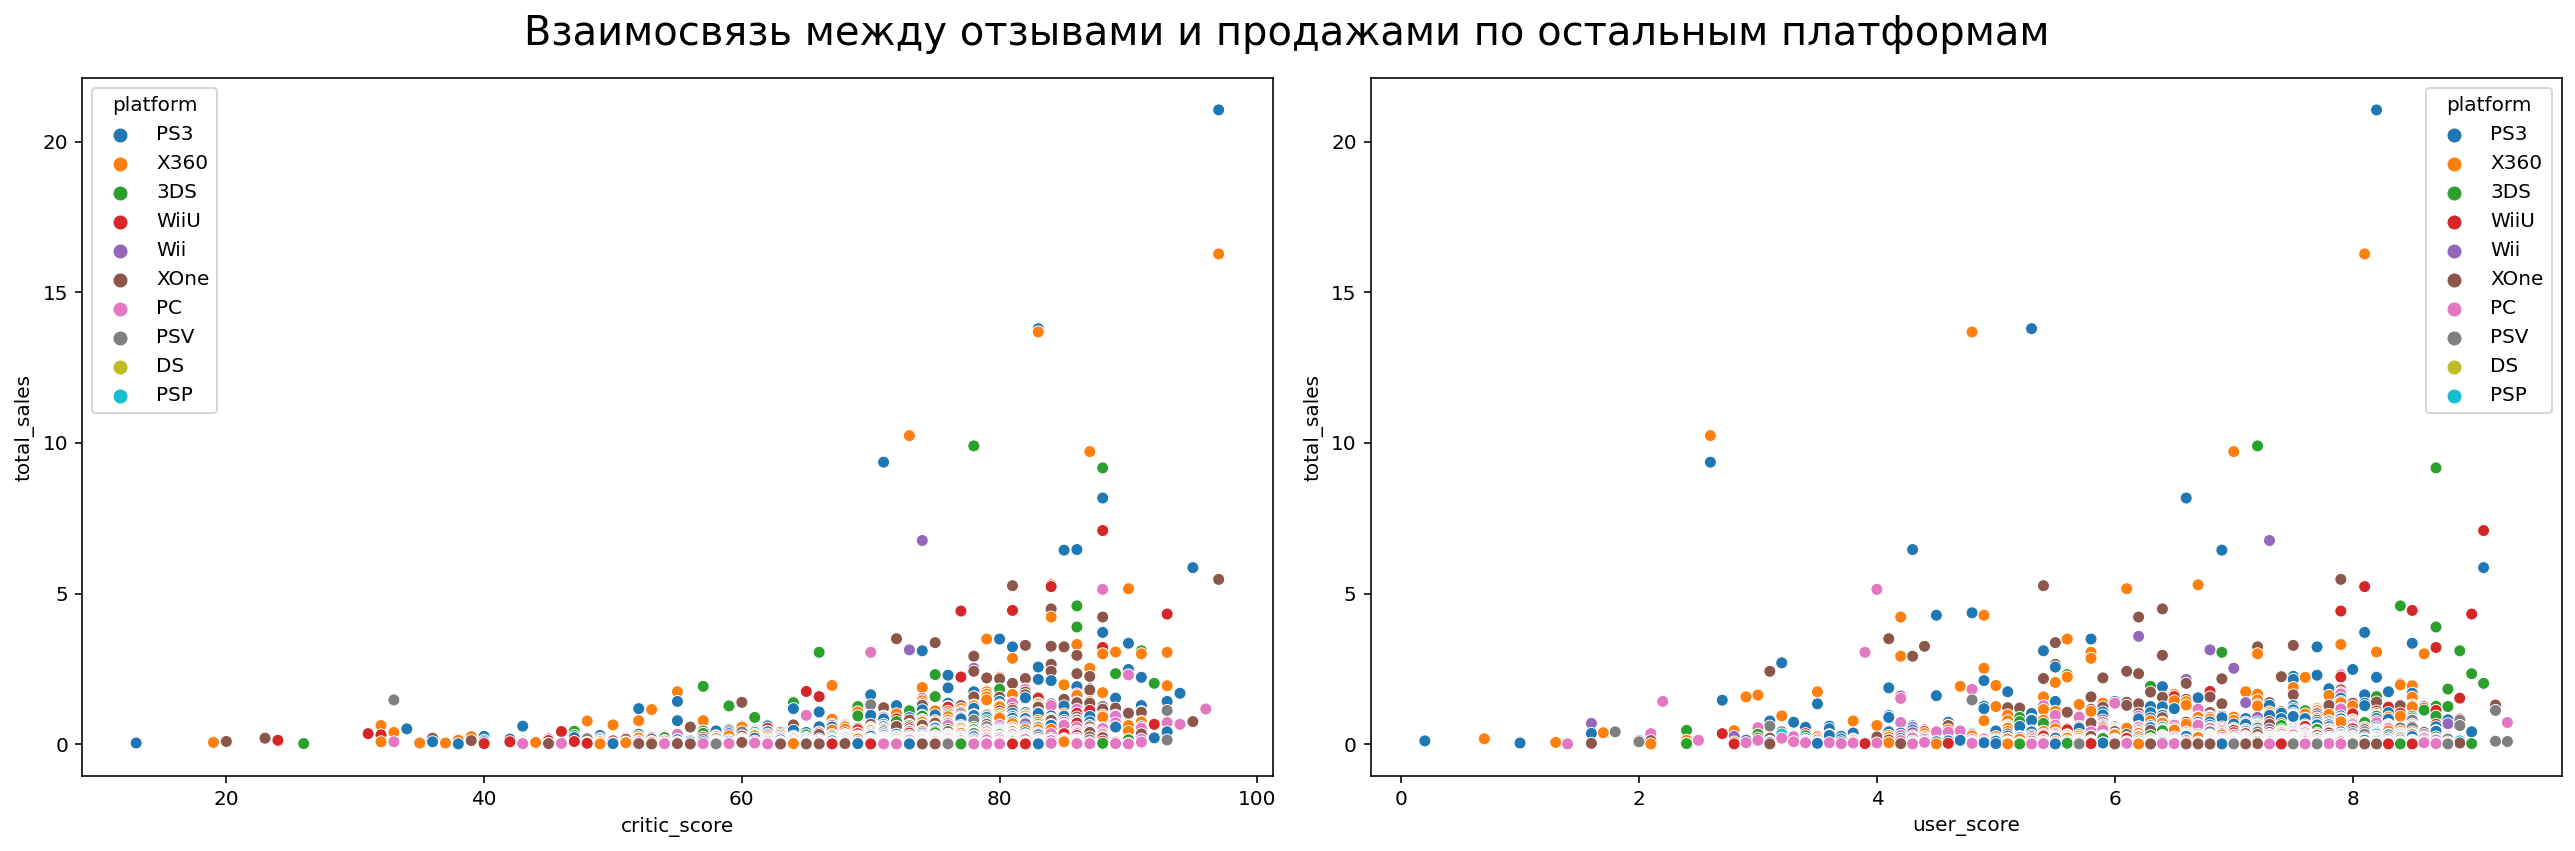

In [32]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('Взаимосвязь между отзывами и продажами по остальным платформам', fontsize=20)
sns.scatterplot(x='critic_score', y='total_sales', 
                    data=data_filtered.query('critic_score > 0 and platform != "PS4"'), hue='platform', ax=axs[0])
sns.scatterplot(x='user_score', y='total_sales', 
                    data=data_filtered.query('user_score > 0 and platform != "PS4"'), hue='platform', ax=axs[1])
fig.tight_layout()

In [33]:
def score_sale_corr(platform):
    corr_critic = (data_filtered[(data_filtered['platform'] == platform) &
                                 (data_filtered['critic_score'] > 0)]['critic_score']
                   .corr(data_filtered[data_filtered['platform'] == platform]['total_sales']))
    corr_user = (data_filtered[(data_filtered['platform'] == platform) &
                              (data_filtered['user_score'] > 0)]['user_score']
                   .corr(data_filtered[data_filtered['platform'] == platform]['total_sales']))
    return print(f'{platform}: {corr_critic:.2}, {corr_user:.2}')

# коэффициенты корреляции по остальным платформам
for i in data_filtered[data_filtered['platform'] != 'PS4']['platform'].unique():
    score_sale_corr(i)

PS3: 0.33, -0.0051
X360: 0.36, 0.0062
3DS: 0.32, 0.2
DS: nan, 0.88
XOne: 0.42, -0.069
WiiU: 0.35, 0.4
Wii: -0.42, 0.3
PC: 0.24, -0.12
PSV: 0.094, -0.0043
PSP: nan, -0.8


По другим платформам в целом также наблюдается слабая зависимость между высокими оценками критиков и продажами. По платформам DS, Wii, PSP для расчета корреляции данных недостаточно, также было много пропущенных значений, поэтому выводы по ним сформулировать не представляется возможным.<br>
Касаемо оценок пользователей, зависимости с продажами в целом не прослеживается, как и по ранее проанализированной платформе. Однако по платформе WiiU видна слабая зависимость.

### Распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам, определим наиболее прибыльные, с наибольшими и наименьшими продажами.

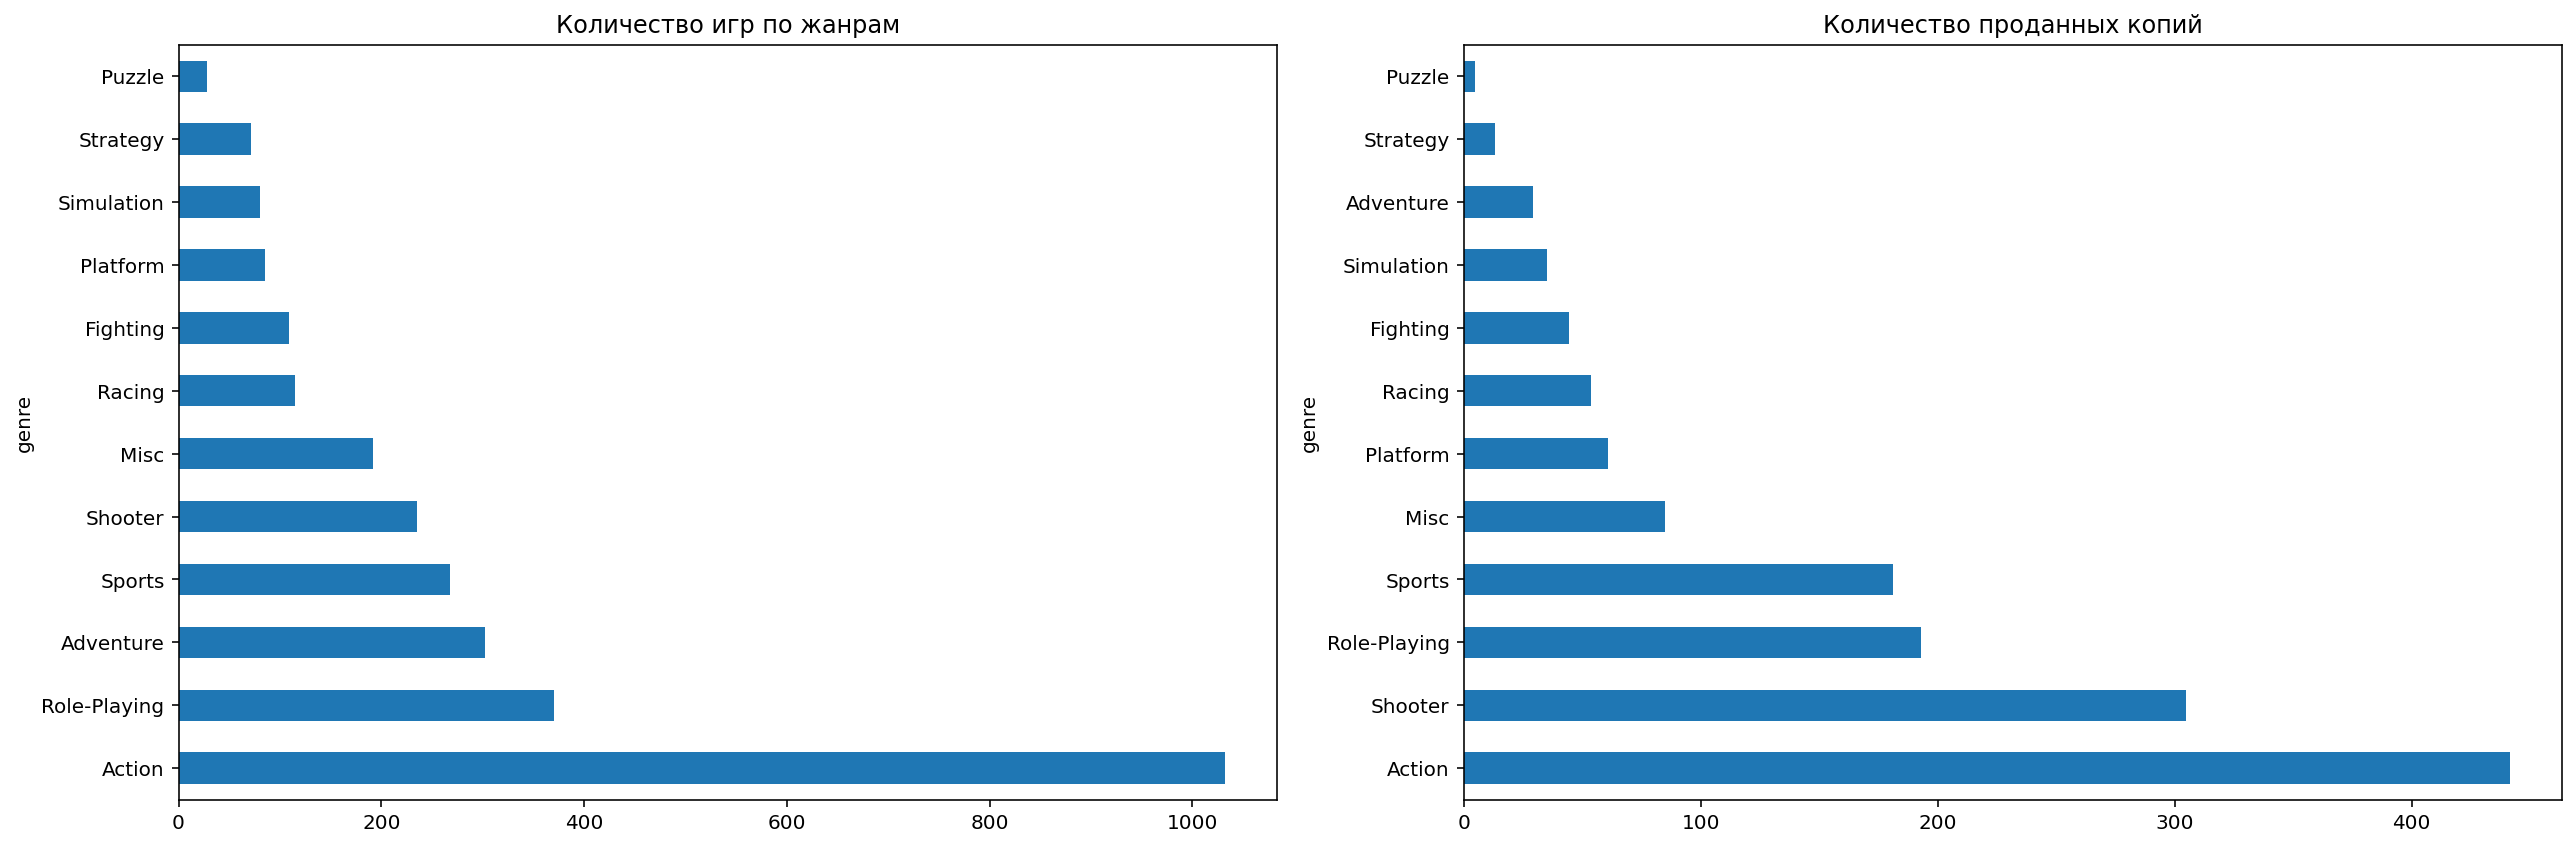

In [34]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
axs[0].set_title('Количество игр по жанрам')
axs[1].set_title('Количество проданных копий')

(data_filtered.pivot_table(index='genre', values='name', aggfunc='count')
 .sort_values(by='name', ascending=False)
 .plot(kind='barh', legend=False, ax=axs[0]))

(data_filtered.pivot_table(index='genre', values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .plot(kind='barh', legend=False, ax=axs[1]))

fig.tight_layout()

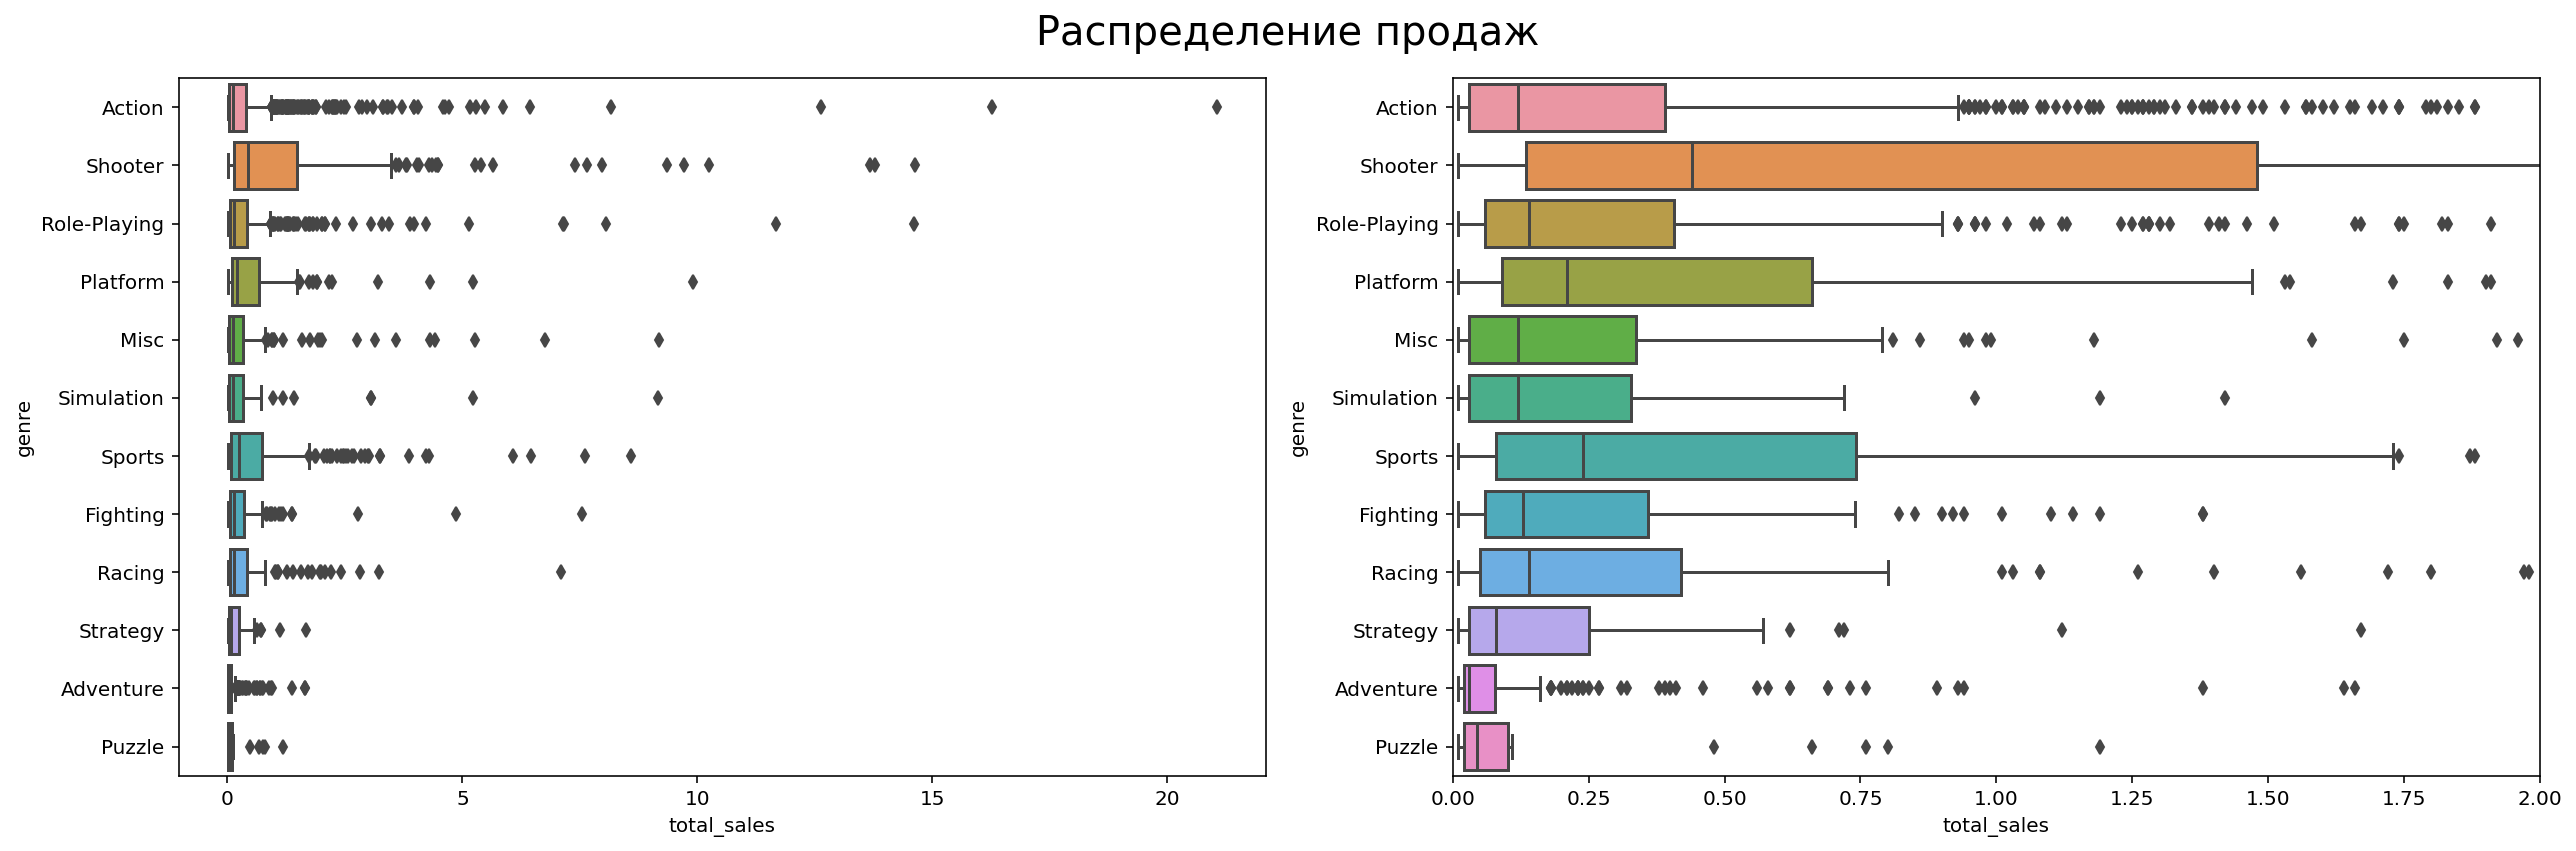

In [35]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('Распределение продаж', fontsize=20)
axs[1].set_xlim(0,2)

sns.boxplot(y='genre', x='total_sales', data=data_filtered, ax=axs[0])
sns.boxplot(y='genre', x='total_sales', data=data_filtered, ax=axs[1])

fig.tight_layout()

Топ-3 жанра по количеству игр:
- Action;
- Role-playing;
- Adventure.

Топ-3 жанра по количеству продаж:
- Action;
- Shooter;
- Role-Playing.

В жанре Action иногда попадаются игры, проданные в огромных количествах, и в целом количество игр намного выше, чем в остальных жанрах. Однако медианные продажи составляю всего 0.12 млн копий. Жанр Shooter при небольшом количестве игр выдает высокие продажи - медианные продажи составляют 0.44 млн копий, у 25% игр количество проданных копий составляет более 1.48 млн шт. Продажи по жанру Sports также показывают неплохие результаты - медианное значение 0.24 млн копий, 25% игр продаются в количестве более 0.74 млн копий. Схожие результаты у жанра Platform.

Таким образом, с точки зрения прибыльности лидерами являются следующие жанры:
- Shooter;
- Sports;
- Platform.

Аутсайдеры:
- Adventure;
- Puzzle.

**Вывод**

В результате проведенного исследовательского анализа получены следующие выводы:
- Наиболее активно игры производились с 1993 года, пик продаж в 2008-2009 годах;
- Платформы с наибольшими суммарными продажами: PS2, X360, PS3, Wii, DS, PS;
- Средний жизненный цикл платформы 6-9 лет, за исключением PC;
- Границы актуального периода для анализа - с 2012 по 2016 гг.;
- Потенциально прибыльные платформы: PS4, XOne, PC;
- Высокие оценки критиков (более 70) в некоторое степени положительно влияют на продажи;
- Оценки пользователей в целом не оказывают влияния на продажи;
- Самые прибыльные жанры: Shooter, Sports, Platform
- Наименее прибыльне: Adventure, Puzzle.

## Определение портрета пользователя каждого региона
<a id='4'></a>

Определим для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5);
- Самые популярные жанры (топ-5);
- Влияние рейтинга ESRB на продажи.

In [36]:
def top_5_and_others(indicator, values):
    '''
    Отбирает топ-5 платформ или жанров (indicator) по значениям продаж values в регионах,
    оставшиеся группирует в категорию Others, объединяет топ-5 и Others и выводит итоговый датафрейм
    '''
    # группируем датафрейм по платформам или жанрам, сортируем по убыванию продаж
    df = (data_filtered.pivot_table(index=indicator, values=values, aggfunc='sum')
                   .sort_values(by=values, ascending=False))
    # выбираем топ-5 по продажам
    top_5 = df.iloc[:5]
    # оставшиеся объединяем в others и суммируем продажи
    others = pd.DataFrame({values: df.iloc[5:][values].sum()}, index=['Others'])
    # получаем датафрейм с топ-5 и others
    grouped_df = pd.concat([top_5, others])
    return grouped_df

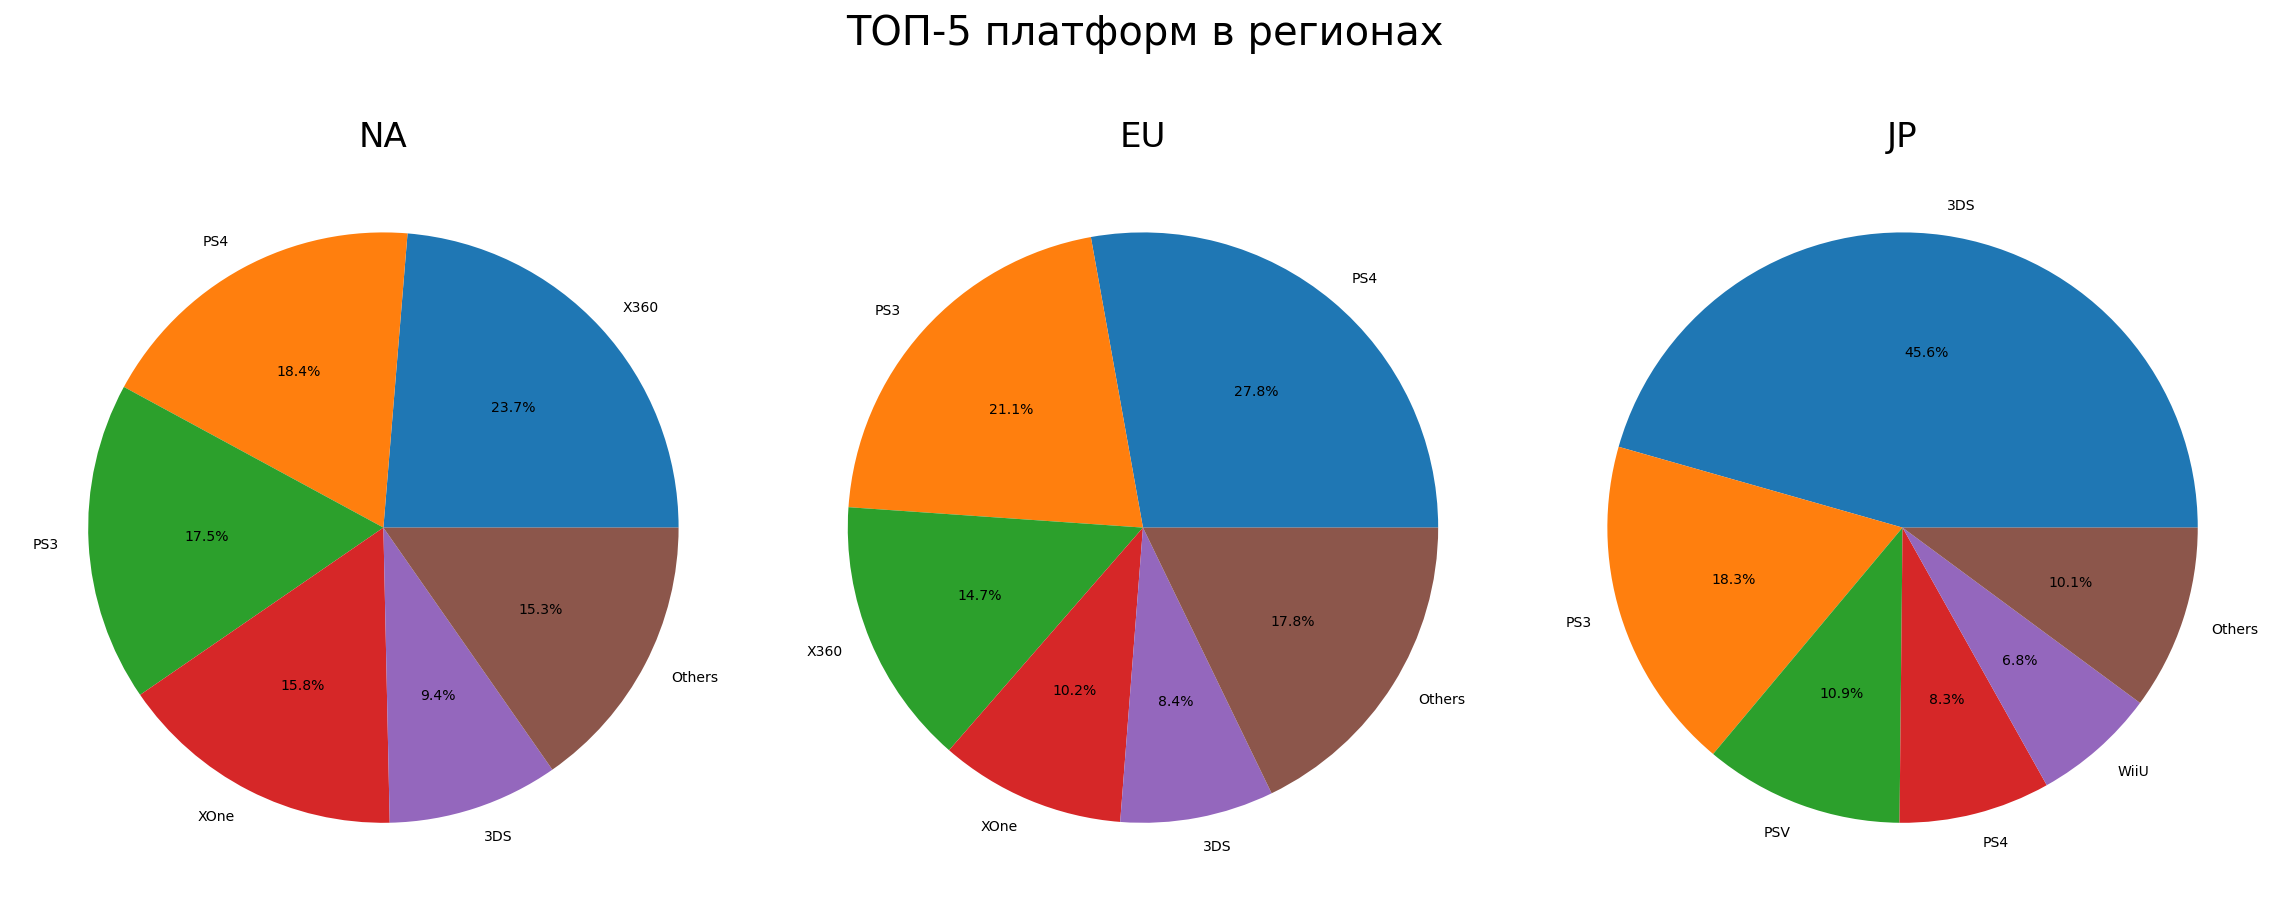

In [37]:
sales = ['na_sales', 'eu_sales', 'jp_sales']
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('ТОП-5 платформ в регионах', fontsize=20)

i = 0
for region in sales:
    axes[i].pie(top_5_and_others('platform', region)[region], 
        labels=top_5_and_others('platform', region).index, 
        autopct='%1.1f%%', textprops={'fontsize': 7})
    axes[i].set_title(region[:2].upper(), fontsize=17)
    i+=1
    
fig.tight_layout()

Популярность платформ различается по регионам. Так, в Северной Америке лидирующее место занимает X360, в Европе - PS4, в Японии - 3DS. PS3 входит в тройку лидеров в каждом регионе. Примечательно, что 3DS лидирует в Японии с отрывом более чем в 2 раза от остальных платформ, включая вторую по популярности платформу PS3. В других регионах такой сильной разницы нет. Также стоит отметить, что PC (одна из потенциально прибыльных платформ, определенная на предыдущих шагах) по количеству проданных копий в Японии находится на последнем месте.

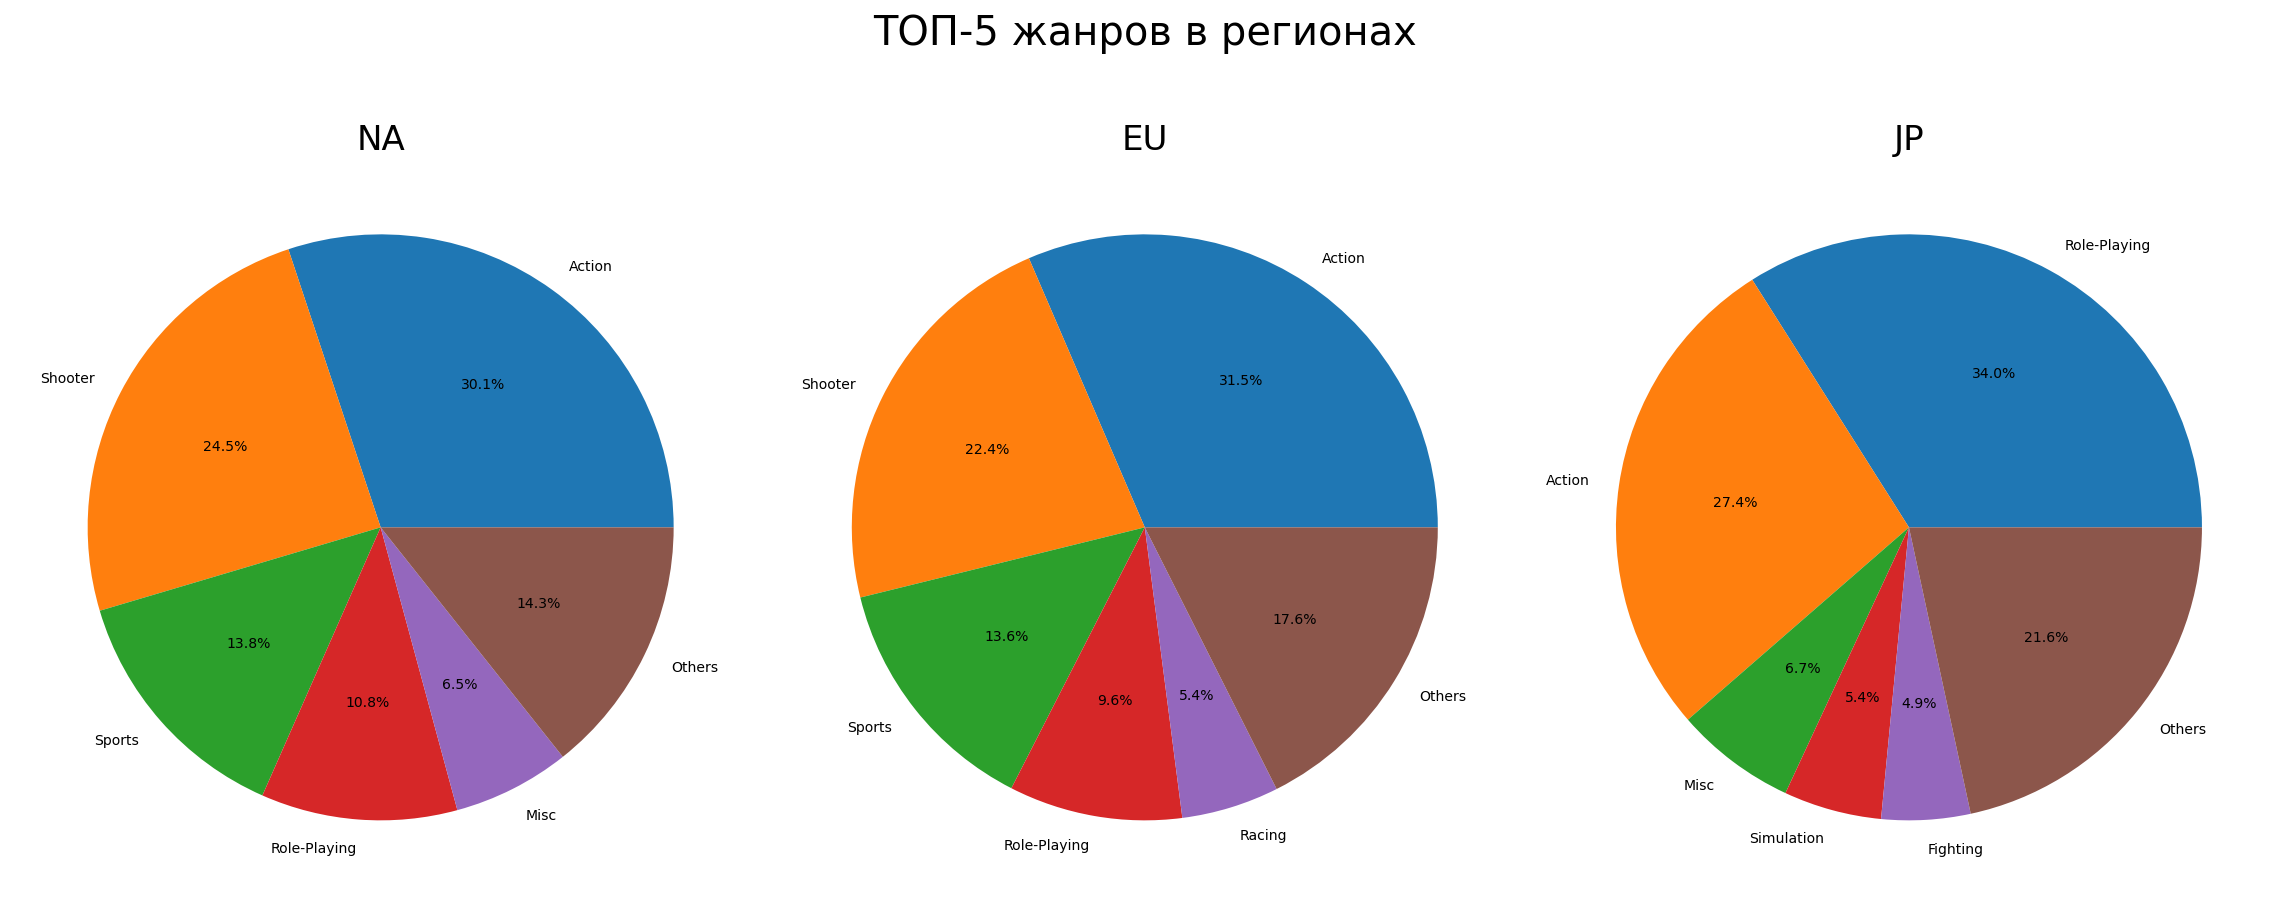

In [38]:
sales = ['na_sales', 'eu_sales', 'jp_sales']
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('ТОП-5 жанров в регионах', fontsize=20)

i = 0
for region in sales:
    axes[i].pie(top_5_and_others('genre', region)[region], 
        labels=top_5_and_others('genre', region).index, 
        autopct='%1.1f%%', textprops={'fontsize': 7})
    axes[i].set_title(region[:2].upper(), fontsize=17)
    i+=1

fig.tight_layout()

Популярные жанры в Северной Америке и Европе примерно совпадают. В Топ-3 обоих регионов попали Action, Shooter и Sports. Однако в Японии с большим отрывом лидируют Role-Playing и Action. Любовь японцев к Role-Playing (RPG) также подтверждается другими исследованиями. В частности, в одном из [исследований](https://app2top.ru/analytics/newzoo-igrovoj-ry-nok-yaponii-zarabotaet-22-1-mlrd-k-kontsu-goda-193587.html) говорится о том, что симпатия к RPG отчасти имеет исторические корни. В Японии зародились такие культовые RPG франшизы, как Final Fantasy, Dragon Quest и Pokémon.

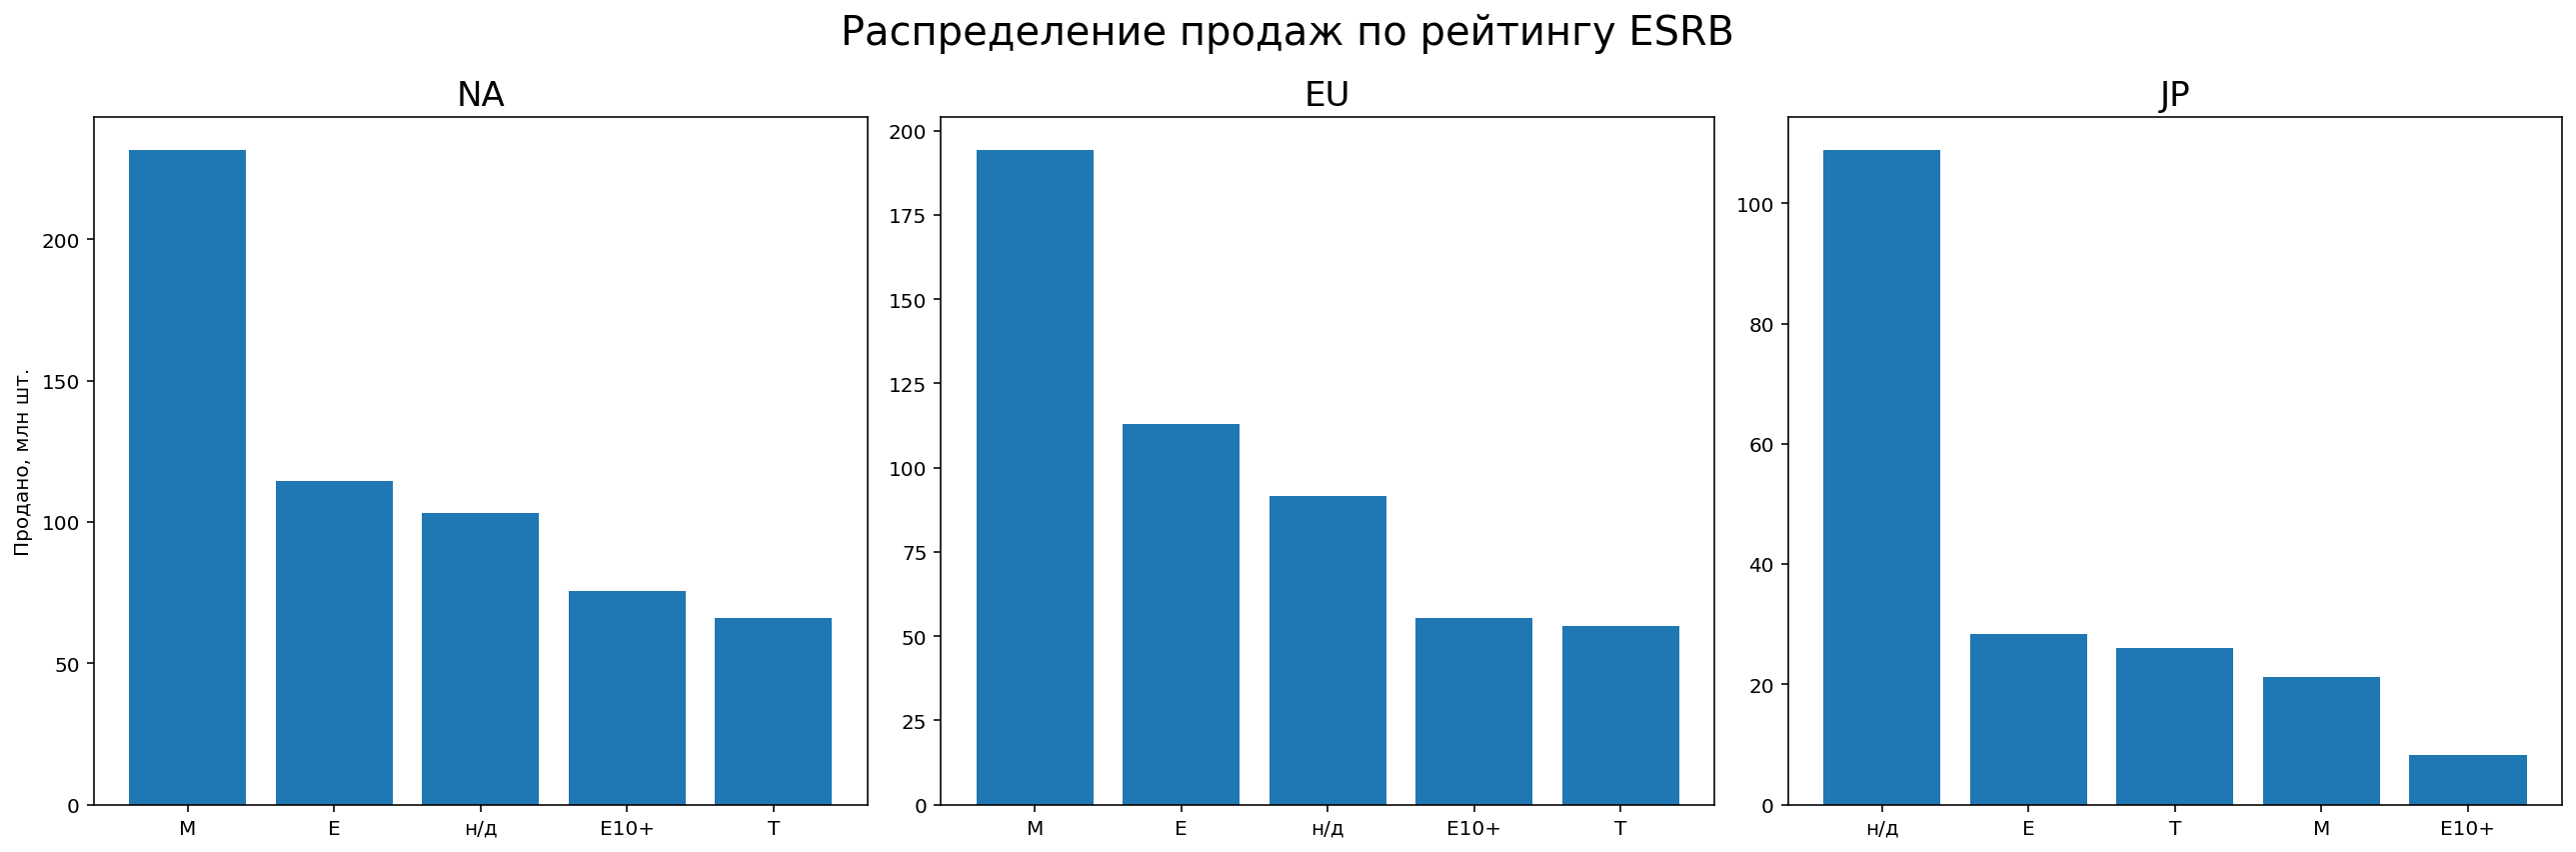

In [39]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Распределение продаж по рейтингу ESRB', fontsize=20)
axes[0].set_ylabel('Продано, млн шт.')

i = 0
for region in sales:
    df = (data_filtered.pivot_table(index='rating', values=region, aggfunc='sum')
    .sort_values(by=region, ascending=False)).reset_index()
    axes[i].bar(df['rating'], df[region])
    axes[i].set_title(region[:2].upper(), fontsize=17)
    i+=1

fig.tight_layout()

В Северной Америке и Европе больше всего продано игр с рейтингами M ("для взрослых") и E ("для всех"). Возможно, это обусловлено тем, что данные категории охватывают наибольшую аудиторию. По большинству игр в Японии в датасете нет данных о рейтинге. Дело в том, что рейтинг ESRB предназначен для маркировки игр для США и Канады. Логично, что для других регионов он не заполняется. То есть в данном случае пропуск в столбце rating имеет признак того, что игра выпущена не в Северо-Американском регионе.  

**Вывод**

**Портрет пользователя Северной Америки:**
- Топ-5 популярных платформ: X360, PS4, PS3, XOne, 3DS;
- Топ-5 популярных жанров: Action, Shooter, Sports, Role-Playing, Misc;
- Наибольшие продажи с рейтингами М и Е.

**Портрет пользователя Европы:**
- Топ-5 популярных платформ: PS4, PS3, X360, XOne, 3DS;
- Топ-5 популярных жанров: Action, Shooter, Sports, Role-Playing, Racing;
- Наибольшие продажи с рейтингами М и Е.

**Портрет пользователя Японии:**
- Топ-5 популярных платформ: 3DS, PS3, PSV, PS4, WiiU;
- Топ-5 популярных жанров: Role-Playing, Action, Misc, Simulation, Fighting.

## Проверка гипотез
<a id='5'></a>

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза Н0: Средние пользовательские рейтинги платформ Xbox One и PC равны.<br>
Альтернативная гипотеза Н1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [40]:
# Применяем метод для проверки гипотезы о равенстве среднего 
# двух генеральных совокупностей по взятым из них выборкам

alpha = .01 

results = st.ttest_ind(
    data_filtered.query('platform == "XOne" and user_score > 0')['user_score'], 
    data_filtered.query('platform == "PC" and user_score > 0')['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5970211251516371
Не получилось отвергнуть нулевую гипотезу


In [41]:
# средний рейтинг Xbox по выборке
data_filtered.query('platform == "XOne" and user_score > 0')['user_score'].mean()

6.52142857142857

In [42]:
# средний рейтинг PC по выборке
data_filtered.query('platform == "PC" and user_score > 0')['user_score'].mean()

6.438647342995167

### Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза Н0: Средние пользовательские рейтинги жанров Action и Sports равны.<br>
Альтернативная гипотеза Н1: Средние пользовательские рейтинги жанров Action и Sports отличаются.

In [43]:
# Применяем метод для проверки гипотезы о равенстве среднего 
# двух генеральных совокупностей по взятым из них выборкам

alpha = .01 

results = st.ttest_ind(
     data_filtered.query('genre == "Action" and user_score > 0')['user_score'], 
     data_filtered.query('genre == "Sports" and user_score > 0')['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.8733525657180856e-26
Отвергаем нулевую гипотезу


In [44]:
# средний пользовательский рейтинг жанра Action
action_avg = data_filtered.query('genre == "Action" and user_score > 0')['user_score'].mean()
action_avg

6.828244274809171

In [45]:
# средний пользовательский рейтинг жанра Sports
sports_avg = data_filtered.query('genre == "Sports" and user_score > 0')['user_score'].mean()
sports_avg

5.455897435897437

In [46]:
(action_avg/sports_avg - 1) * 100

25.153457429061767

**Вывод**

В результате проведенного стат.теста получены следующие результаты:
- Средние пользовательские рейтинги платформ Xbox One и PC примерно одинаковые (по выборке средняя оценка пользователей 6.5);
- Средние пользовательские рейтинги жанров Action и Sports разные (по выборке средняя оценка пользователей по жанру Action на 25% выше).

## Общий вывод
<a id='6'></a>

Можно выделить следующие факторы, определяющие потенциально прибыльную игру:
- платформы: PS4, XOne, PC;
- высокие оценки критиков (более 70);
- жанры: Shooter, Sports, Platform.


При этом стоит учитывать предпочтения пользователей в зависимости от регионов (п.4.1 Вывод). У ряда платформ (PS3, X360, 3DS, WiiU) популярность падает, есть основания полагать, что в прогнозном периоде (2017 год) падение продаж продолжится и платформы окончательно уйдут с рынка (график в п.3.4). PC хоть и не подвержена стандартному жизненному циклу в 6-9 лет, уровень продаж стабильно снижается с 2011 года и, возможно, продолжится в следующем году. Данные факты следует принять во внимание при планировании рекламной кампании на 2017 год.

**Следует сконцентрировать рекламную кампанию на PS4 и XOne, жанр Shooter, рейтинг ESRB "M" и "E", Северо-Американский регион, также стоит ориентироваться на высокие оценки критиков (более 70).**